# Universidad Nacional de Rosario - Facultad de Ciencias Exactas, Ingeniería y Agrimensura.
## Tecnicatura Universitaria en Programación.
### Procesamiento del Lenguaje Natural: Trabajo Práctico N°2.

---

**Autora: López Ceratto, Julieta : L-3311/1**

Se desarrolla a continuación el trabajo práctico final de la asignatura mencionada, cuyo objetivo es realizar un asistente destinado a brindar información o resolver consultas acerca del juego asignado.

# Parte 0: importar recursos y librerías.

Instalamos los recursos y librerías necesarias.

In [6]:
%%capture
! pip install selenium
! pip install langdetect
! pip install import os
import gdown
! pip install tensorflow tensorflow-text
! pip install pydub
! pip install SpeechRecognition
! pip install PyPDF2
! pip install chromadb
! pip install python-decouple
! pip install deep-translator
!pip install rdflib
!python -m spacy download es_core_news_sm
!pip install llama-index-llms-ollama
!pip install wikipedia
!pip install litellm[proxy]
!pip install llama-index
!pip install rank-bm25
!pip install nltk
!apt-get update
!pip install selenium webdriver-manager


Importamos librerías necesarias.

In [7]:
%%capture
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import re
from langdetect import detect
import networkx as nx
import plotly.graph_objects as go
import numpy as np
import rdflib
import urllib.parse
from rdflib import Namespace
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import sentencepiece
from pydub import AudioSegment
import speech_recognition as sr
import os
from langchain.text_splitter import RecursiveCharacterTextSplitter
import PyPDF2
import chromadb
from chromadb.config import Settings
import requests
import json
from decouple import config, Config, Csv
from jinja2 import Template
import pandas as pd
from deep_translator import GoogleTranslator
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from huggingface_hub import InferenceClient
from typing import List, Dict, Any
import spacy
from llama_index.core import Settings
from llama_index.llms.ollama import Ollama
from llama_index.core.agent import ReActAgent
from llama_index.core.tools import FunctionTool
import wikipedia
from chromadb.config import Settings
from llama_index.core.agent.react.formatter import ReActChatFormatter
from rank_bm25 import BM25Okapi
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
nltk.data.path.append('/root/nltk_data/tokenizers/punkt')
from typing import List, Dict, Any
import os
import gdown

Importamos archivos a utilizar.

In [8]:
# URL para listar el contenido de la carpeta pública
%%capture
url = f"https://drive.google.com/drive/folders/1KEmzDzQqhampnxn7wnNgSVdbJ7VobsA-?usp=sharing"

# Descargar la carpeta completa (requiere que el contenido sea público)
gdown.download_folder(url, output="tp-folder", quiet=False, use_cookies=False)

Agregamos a path del sistema la ubicación de la carpeta descargada e importamos módulo que obtiene el token de huggin face.

In [9]:
import sys
sys.path.append('/content/tp-folder')
from token_huggin_face import get_token

# Parte 1: Base de datos de Grafos.

La base de datos de grafos se utiliza para modelar datos acerca del juego que no tienen que ver de manera estricta con su jugabilidad y que no son de amplia explicación, sino más bien relaciones entre distintas personas, otros juegos, premios y nacionalidades.
Incluye:
- Nombres alternativos.
- Diseñadores: nombres, nacionalidad, relaciones entre ellos, premios ganados, otros juegos hechos.
- Artistas: nombre, nacionalidad, relación con diseñadores, premios, otros juegos.
- Publicadores: nombres, nacionalidad.
- Juegos de su colección / familia: nombres, relación con diseñadores y artistas del mismo juego.

## Primeramente se debe extraer la información.

### Encontrar links

Se encuentran todos los links necesarios para obtener información pertinente para la base de grafos.

In [ ]:
## Url de partida
url_credits = "https://boardgamegeek.com/boardgame/220877/rajas-of-the-ganges/credits"

In [ ]:
#Url
def encontrar_url(dato:str)->list:
    # Como tienen carga con JavaScript utilizo selenuim.
    # Configuración de Selenium
    # Configuración más detallada de las opciones de Chrome
    chrome_options = Options()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument('--disable-gpu')

    # Configurar la ruta del driver
    service = Service('/usr/bin/chromedriver')

    driver = webdriver.Chrome(options=chrome_options)


    # URL del sitio web
    url = "https://boardgamegeek.com/boardgame/220877/rajas-of-the-ganges/credits"
    driver.get(url)
    url = []
    finder = f'a.ng-binding[ng-href*="/boardgame{dato}/"]'
    links = driver.find_elements(By.CSS_SELECTOR, finder)
    # Extraer los href
    url = [link.get_attribute('href') for link in links]
    driver.close()
    return url

url_designers = encontrar_url('designer')
url_artists = encontrar_url('artist')
url_publishers = encontrar_url('publisher')
url_related_to = encontrar_url('family')


In [ ]:
print(url_designers,url_artists ,url_publishers ,url_related_to )

['https://boardgamegeek.com/boardgamedesigner/6940/inka-brand', 'https://boardgamegeek.com/boardgamedesigner/6941/markus-brand'] ['https://boardgamegeek.com/boardgameartist/12484/dennis-lohausen'] ['https://boardgamegeek.com/boardgamepublisher/3490/huch', 'https://boardgamegeek.com/boardgamepublisher/267/999-games', 'https://boardgamegeek.com/boardgamepublisher/2366/devir', 'https://boardgamegeek.com/boardgamepublisher/46544/dice-realm', 'https://boardgamegeek.com/boardgamepublisher/917/dv-games', 'https://boardgamegeek.com/boardgamepublisher/7496/egmont-polska', 'https://boardgamegeek.com/boardgamepublisher/37681/fabrika-igr', 'https://boardgamegeek.com/boardgamepublisher/12540/game-harbor', 'https://boardgamegeek.com/boardgamepublisher/17130/hot-games', 'https://boardgamegeek.com/boardgamepublisher/52507/nostalgia-iii', 'https://boardgamegeek.com/boardgamepublisher/105/r-and-r-games'] ['https://boardgamegeek.com/boardgamefamily/22783/admin-better-description-needed', 'https://boardga

### Encontrar informacion dentro de cada link

Defino información que quiero encontrar según cada link:
- Designer: Nombre, Pareja(si la tiene), Premios ganados, Otros juegos, nacionalidad.
- Artist: Nombre, Pareja(si la tiene), Premios ganados, Otros juegos, nacionalidad.
- Family: temática con las que se relaciona el juego.
- Publishers: Nombre.
- Nombres Alternativos: Nombre, idioma.
- Año de publicación.
- Premios: nombre de premio ganado, año.
            

In [ ]:
def encontrar_datos(entidad, lista_url)->dict:
    lista_dict = []
    # Como tienen carga con JavaScript utilizo selenuim.
    # Configuración de Selenium
    chrome_options = Options()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument('--disable-gpu')

    # Configurar la ruta del driver
    service = Service('/usr/bin/chromedriver')

    driver = webdriver.Chrome(options=chrome_options)

    if entidad == 'designer' or entidad == 'artist':

        for url in lista_url:
            driver.get(url)
            finder = f'a.ng-binding[ng-href*="/boardgame{entidad}/"]'
            links = driver.find_element(By.CSS_SELECTOR, finder)
            name_designer = links.text.strip()
            # Esperar hasta que la imagen esté cargada
            WebDriverWait(driver, 3).until(EC.presence_of_all_elements_located((By.XPATH, "//img[contains(@alt, 'Microbadge:')]")))
            # Encontrar todas las etiquetas <img> con Microbadge
            img_elements = driver.find_elements(By.XPATH, "//img[contains(@alt, 'Microbadge:')]")

            # Verificar si hay más de un microbadge
            if len(img_elements) > 1:
                # Tomar el segundo microbadge (índice 1)
                second_img = img_elements[1]
                # Extraer el atributo 'alt'
                alt_text = second_img.get_attribute("alt")
                # Limpiar el texto para obtener solo el nombre
                partner = alt_text.replace("Microbadge: ", "").replace(" fan", "").strip()
            else:
                partner = ''
            # Buscar el enlace que contiene el nombre del premio
            try:
                award = driver.find_element(By.CSS_SELECTOR, 'a.ng-binding[ng-href*="/boardgamehonor/"]')
                award = award.text.strip()  # Elimina espacios extra al inicio y fin
            except:
                award = ''


            see_all_button = WebDriverWait(driver, 3).until(
                EC.presence_of_element_located((By.XPATH, "//a[contains(text(), 'See All')]"))
            )
            # Extraer el enlace del botón
            see_all_link = see_all_button.get_attribute("href")

             # Navegar al enlace extraído
            driver.get(see_all_link)

            # Esperar hasta que los nombres estén cargados
            WebDriverWait(driver, 3).until(
                EC.presence_of_all_elements_located((By.XPATH, "//h3[@class='summary-item-title summary-item-title-separated fs-inherit mb-0']/a"))
            )

            # Extraer los primeros 10 nombres
            name_other_games = driver.find_elements(By.XPATH, "//h3[@class='summary-item-title summary-item-title-separated fs-inherit mb-0']/a")[:10]
            other_games = [name.text.strip() for name in name_other_games]

            dict = {'Name': name_designer, 'Partner': partner, 'Award': award, 'Other Games': other_games}
            lista_dict.append(dict)

    elif entidad == 'publisher':

        for url in lista_url:
            driver.get(url)
            finder = f'a.ng-binding[ng-href*="/boardgame{entidad}/"]'
            links = driver.find_element(By.CSS_SELECTOR, finder)
            name_publisher = links.text.strip()
            dict = {'Name': name_publisher}
            lista_dict.append(dict)

    elif entidad == 'related_to':
        for url in lista_url:
            driver.get(url)
            finder = f'a.ng-binding[ng-href*="/boardgamefamily/"]'
            links = driver.find_element(By.CSS_SELECTOR, finder)
            subject = links.text.strip()
            # Dividir en temática y nombre
            if ":" in subject:
                partes = subject.split(":", 1)  # Dividir solo en el primer ":"
                tematica = partes[0].strip()  # Eliminar espacios en exceso
                nombre = partes[1].strip()  # Eliminar espacios en exceso
            else:
                tematica = subject.strip()
                nombre = ""  # Si no hay ":", dejar el nombre vacío

            # Crear el diccionario
            dict = {'Subject': tematica, 'Name': nombre}
            lista_dict.append(dict)
    elif entidad == 'alternative_names':
        driver.get(lista_url)
        try:
            # Esperar hasta que los nombres alternativos estén cargados
            WebDriverWait(driver, 3).until(
                EC.presence_of_all_elements_located((By.XPATH, "//div[@ng-switch-when='alternatename']"))
            )

            # Encontrar todos los nombres alternativos
            alt_name_elements = driver.find_elements(By.XPATH, "//div[@ng-switch-when='alternatename']")
            alt_names = [element.text.strip() for element in alt_name_elements if element.text.strip()]

            for name in alt_names:
                dict = {'Alternative Name' : name}
                lista_dict.append(dict)
        except:
            lista_dict = None


        return lista_dict
    elif entidad == 'award_game':
        driver.get(lista_url)
        try:
            # URL inicial
            url = "https://boardgamegeek.com/boardgame/220877/rajas-of-the-ganges"
            driver.get(url)

            # Esperar a que los elementos <a> con premios estén cargados
            WebDriverWait(driver, 3).until(
                EC.presence_of_all_elements_located((By.XPATH, "//a[@class='ng-binding']"))
            )

            # Encontrar todos los premios
            awards_elements = driver.find_elements(By.XPATH, "//a[@class='ng-binding'][contains(@ng-href, '/boardgamehonor/')]")

            # Lista para almacenar los premios procesados
            awards_list = []

            for award in awards_elements:
                text = award.text.strip()
                # Separar el año del nombre del premio usando una expresión regular
                match = re.match(r"(\d{4})\s*(.*)", text)
                if match:
                    year = match.group(1)
                    name = match.group(2).strip()
                    awards_list.append({'year': year, 'name': name})
            for award in awards_list:
                dict = {'Prize': award['name'], 'Year': award['year']}
                lista_dict.append(dict)
        except:
            lista_dict = None
    driver.close()
    return lista_dict

In [ ]:
dict_desingers =  encontrar_datos('designer', url_designers)
dict_artist = encontrar_datos('artist', url_artists)
dict_publishers = encontrar_datos('publisher', url_publishers)
dict_related_to = encontrar_datos('related_to', url_related_to)
dict_alternative_names = encontrar_datos('alternative_names', url_credits)
dict_awards = encontrar_datos('award_game', url_credits)

In [ ]:
for designer in dict_desingers:
    designer['Nacionalidad'] = 'German'
for artist in dict_artist:
    artist['Nacionalidad'] = 'German'

In [ ]:
dict_desingers

[{'Name': 'Inka Brand',
  'Partner': 'Markus Brand',
  'Award': '2012 Spiel des Jahres Kennerspiel des Jahres Winner',
  'Other Games': ['Andor Junior: Die Fährtenleserin Fennah / Der Fährtenleser Fenn (2020)',
   'Andor: The Family Fantasy Game (2020)',
   'Andor: The Family Fantasy Game – The Danger in the Shadows (2022)',
   'Bibi & Tina: Das Spiel zum Film (2013)',
   'Bitte nicht öffnen: Bissig! (2022)',
   'Black Stories: Das Spiel (2022)',
   'Blitzed! (2013)',
   'La Boca (2013)',
   'Bravo! (2019)',
   'Burgenland (2014)'],
  'Nacionalidad': 'German'},
 {'Name': 'Markus Brand',
  'Partner': 'Inka Brand',
  'Award': '2012 Spiel des Jahres Kennerspiel des Jahres Winner',
  'Other Games': ['Andor Junior: Die Fährtenleserin Fennah / Der Fährtenleser Fenn (2020)',
   'Andor: The Family Fantasy Game (2020)',
   'Andor: The Family Fantasy Game – The Danger in the Shadows (2022)',
   'Bibi & Tina: Das Spiel zum Film (2013)',
   'Bitte nicht öffnen: Bissig! (2022)',
   'Black Stories: 

In [ ]:
dict_artist

[{'Name': 'Dennis Lohausen',
  'Partner': '',
  'Award': '',
  'Other Games': ['100! (2014)',
   '1001 Karawane (2007)',
   '1001 Karawane: Sonderchips (2007)',
   '112: Brandgefährlich (2017)',
   '15 (2011)',
   'The Academy (2023)',
   'Adventure Land (2023)',
   'Agent DOG (2024)',
   'Albion (2009)',
   'All Change! (and Chameleon) (2017)'],
  'Nacionalidad': 'German'}]

In [ ]:
dict_publishers

[{'Name': 'HUCH!'},
 {'Name': '999 Games'},
 {'Name': 'Devir'},
 {'Name': 'Dice Realm'},
 {'Name': 'DV Games'},
 {'Name': 'Egmont Polska'},
 {'Name': 'Fabrika Igr'},
 {'Name': 'Game Harbor'},
 {'Name': 'HOT Games'},
 {'Name': 'nostalgia (III)'},
 {'Name': 'R&R Games'}]

In [ ]:
dict_related_to

[{'Subject': 'Admin', 'Name': 'Better Description Needed!'},
 {'Subject': 'Country', 'Name': 'India'},
 {'Subject': 'Digital Implementations', 'Name': 'Tabletopia'},
 {'Subject': 'Digital Implementations', 'Name': 'Yucata'},
 {'Subject': 'Game', 'Name': 'Rajas of the Ganges'},
 {'Subject': 'Mechanism', 'Name': 'Dice Drafting'},
 {'Subject': 'Religious', 'Name': 'Hinduism'}]

In [ ]:
dict_alternative_names

[{'Alternative Name': 'Ganges'},
 {'Alternative Name': 'I Ragià del Gange'},
 {'Alternative Name': "Raja's van de Ganges"},
 {'Alternative Name': 'Раджи Ганга'},
 {'Alternative Name': 'ガンジスの藩王'},
 {'Alternative Name': '갠지스의 라자'}]

In [ ]:
dict_awards

[{'Prize': 'MinD-Spielepreis Complex Game Nominee', 'Year': '2019'},
 {'Prize': 'Juego del Año Recommended', 'Year': '2018'},
 {'Prize': 'International Gamers Award - General Strategy: Multi-player Winner',
  'Year': '2018'},
 {'Prize': 'International Gamers Award - General Strategy: Multi-player Nominee',
  'Year': '2018'}]

#### Detectar idioma de nombres alternativos

In [ ]:
for alt_name in dict_alternative_names:
    lang = detect(alt_name['Alternative Name'])
    alt_name['Language'] = lang

In [ ]:
dict_alternative_names

[{'Alternative Name': 'Ganges', 'Language': 'de'},
 {'Alternative Name': 'I Ragià del Gange', 'Language': 'ca'},
 {'Alternative Name': "Raja's van de Ganges", 'Language': 'nl'},
 {'Alternative Name': 'Раджи Ганга', 'Language': 'bg'},
 {'Alternative Name': 'ガンジスの藩王', 'Language': 'ja'},
 {'Alternative Name': '갠지스의 라자', 'Language': 'ko'}]

## Armado de base de Grafos

En este apartado se modelará la siguiente base de grafos:

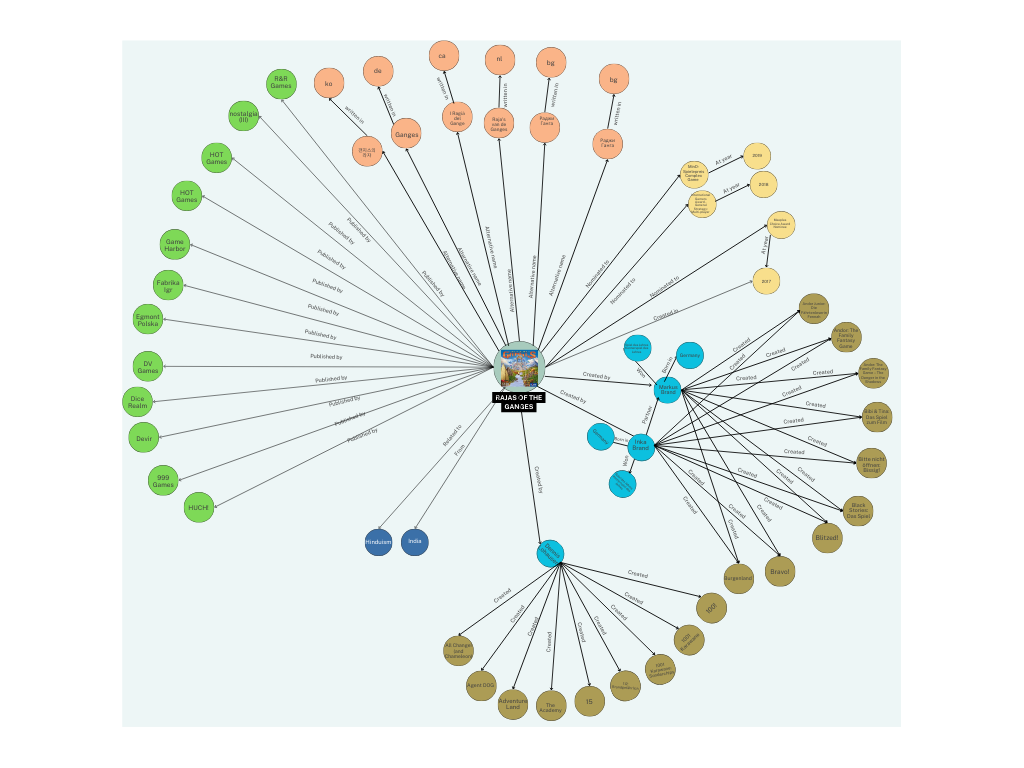

Para verla en mejor detalle: https://www.canva.com/design/DAGYQvwpJa8/_qM5Kdb2sn654E-HB3HwCQ/edit?utm_content=DAGYQvwpJa8&utm_campaign=designshare&utm_medium=link2&utm_source=sharebutton

### Crear el grafo base

In [ ]:
G = nx.DiGraph()
game_node = "Rajas of the Ganges"
G.add_node(game_node, type="game")

# Añadimos nodos de diseñadores y establecemos relación con el juego
for designer in dict_desingers:
    G.add_node(designer['Name'], type="designer", nationality=designer['Nacionalidad'])
    G.add_edge(game_node, designer['Name'], relationship="designed by")
    if designer['Partner']:
        G.add_edge(designer['Name'], designer['Partner'], relationship="partner")

    # Añadir otros juegos que diseñaron
    for other_game in designer['Other Games']:
        G.add_node(other_game, type="game")
        G.add_edge(designer['Name'], other_game, relationship="designed")

        # Añadir los premios de esos otros juegos, si están disponibles en el diccionario de premios
        for award in dict_awards:  # Premios globales del juego "Rajas of the Ganges"
            if award['Prize'] in other_game:  # Si el premio pertenece a este juego (por ejemplo, por nombre o año)
                award_node = f"{award['Year']} - {award['Prize']}"
                G.add_node(award_node, type="award", year=award['Year'])
                G.add_edge(other_game, award_node, relationship="awarded or nominated")

# Añadimos nodo de artista y establecemos relación con el juego
for artist in dict_artist:
    G.add_node(artist['Name'], type="artist", nationality=artist['Nacionalidad'])
    G.add_edge(game_node, artist['Name'], relationship="art by")

    # Añadir otros juegos que hizo el artista
    for other_game in artist['Other Games']:
        G.add_node(other_game, type="game")
        G.add_edge(artist['Name'], other_game, relationship="artist of")

        # Añadir los premios de esos otros juegos
        for award in dict_awards:  # Premios globales del juego "Rajas of the Ganges"
            if award['Prize'] in other_game:  # Si el premio pertenece a este juego (por ejemplo, por nombre o año)
                award_node = f"{award['Year']} - {award['Prize']}"
                G.add_node(award_node, type="award", year=award['Year'])
                G.add_edge(other_game, award_node, relationship="awarded or nominated")

# Publicadores
for publisher in dict_publishers:
    G.add_node(publisher['Name'], type="publisher")
    G.add_edge(game_node, publisher['Name'], relationship="published by")

# País
country = next((item for item in dict_related_to if item['Subject'] == 'Country'), None)
G.add_node(country['Name'], type="country")
G.add_edge(game_node, country['Name'], relationship="set in")

# Religión con la que se relaciona
religion = next((item for item in dict_related_to if item['Subject'] == 'Religious'), None)
G.add_node(religion['Name'], type="religion")
G.add_edge(game_node, religion['Name'], relationship="religion associated with")

# Nombres alternativos
for alt_name in dict_alternative_names:
    G.add_node(alt_name['Alternative Name'], type="alternative name", language=alt_name['Language'])
    G.add_edge(game_node, alt_name['Alternative Name'], relationship="also known as")

# Premios, honores o nominaciones
for award in dict_awards:
    award_node = f"{award['Year']} - {award['Prize']}"
    G.add_node(award_node, type="award", year=award['Year'])
    G.add_edge(game_node, award_node, relationship="awarded or nominated")

#Año
release_year_node = 2017
G.add_node(release_year_node, type = 'year')
G.add_edge(game_node, release_year_node, relationship = "Release year")

In [ ]:

# Generar posiciones de los nodos con un layout de NetworkX
pos = nx.spring_layout(G, seed=42)  # Layout basado en fuerzas para distribuir los nodos

# Extraer las coordenadas de los nodos
x_nodes = [pos[node][0] for node in G.nodes]
y_nodes = [pos[node][1] for node in G.nodes]

# Extraer las relaciones (aristas)
edge_x = []
edge_y = []
edge_labels = []  # Aquí guardaremos las etiquetas de las aristas
edge_midpoints = []  # Para almacenar las posiciones medias de las aristas
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_y.append(y0)
    edge_y.append(y1)

    # Guardamos la relación como etiqueta
    edge_labels.append(G[edge[0]][edge[1]]['relationship'])

    # Calculamos los puntos medios de las aristas
    mid_x = (x0 + x1) / 2
    mid_y = (y0 + y1) / 2
    edge_midpoints.append((mid_x, mid_y))

# Crear el gráfico interactivo con Plotly
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='gray'),
    hoverinfo='none', mode='lines')

node_trace = go.Scatter(
    x=x_nodes, y=y_nodes,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=20,
        colorbar=dict(thickness=15, title='Node Connections', xanchor='left', titleside='right')
    ))

# Añadir información sobre los nodos (nombre, tipo, etc.)
node_text = []
for node in G.nodes():
    node_info = f'{node} ({G.nodes[node].get("type", "unknown")})'
    node_text.append(node_info)

node_trace.marker.color = np.arange(len(G.nodes))  # Colores por nodo
node_trace.text = node_text  # Información que aparece al pasar el ratón por encima

# Añadir las etiquetas de las relaciones (aristas) en el punto medio de cada arista
edge_trace_text = go.Scatter(
    x=[mid[0] for mid in edge_midpoints], y=[mid[1] for mid in edge_midpoints],
    mode='text',
    text=edge_labels,
    textposition='middle center',
    hoverinfo='none',
    showlegend=False,
    textfont=dict(size=10, color="black", family="Arial")
)

# Crear el layout interactivo
layout = go.Layout(
    title='Interactive Network Graph of Rajas of the Ganges',
    titlefont_size=16,
    showlegend=False,
    hovermode='closest',
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False),
    plot_bgcolor='white'
)
# Añadir las etiquetas de los nodos (nombre de la entidad) sobre los nodos
node_trace_text = go.Scatter(
    x=x_nodes, y=[y + 0.05 for y in y_nodes],  # Ajuste de posición para que el texto esté encima de los nodos
    mode='text',
    text=node_text,
    textposition='bottom center',  # Asegura que el texto esté por encima del nodo
    hoverinfo='none',
    showlegend=False,
    textfont=dict(size=10, color="black", family="Arial")
)

# Crear la figura de Plotly con los cambios
fig = go.Figure(data=[edge_trace, node_trace, edge_trace_text, node_trace_text], layout=layout)

# Mostrar el gráfico interactivo
fig.show()

### Crear grafo RDF

In [ ]:
# Crear un grafo RDF vacío
g = rdflib.Graph()

# Definir los prefijos
ex = rdflib.Namespace("http://wiki_rajas.org/")
g.bind("ex", ex)

# Función para codificar los nombres a formato URI válido
def encode_to_uri(name):
    return urllib.parse.quote(name.replace(" ", "_"))

# Crear el nodo principal (el juego)
game_node = encode_to_uri("Rajas of the Ganges")
g.add((ex[game_node], rdflib.RDF.type, ex.Game))

# Añadir los diseñadores y sus relaciones con el juego
for designer in dict_desingers:
    designer_node = encode_to_uri(designer['Name'])
    g.add((ex[designer_node], rdflib.RDF.type, ex.Designer))
    g.add((ex[game_node], ex.designedBy, ex[designer_node]))  # Relación: juego -> diseñador

    if designer['Partner']:
        partner_node = encode_to_uri(designer['Partner'])
        g.add((ex[designer_node], ex.partner, ex[partner_node]))  # Relación: diseñador -> pareja

# Añadir los artistas y sus relaciones con el juego
for artist in dict_artist:
    artist_node = encode_to_uri(artist['Name'])
    g.add((ex[artist_node], rdflib.RDF.type, ex.Artist))
    g.add((ex[game_node], ex.artBy, ex[artist_node]))  # Relación: juego -> artista

# Añadir los publicadores
for publisher in dict_publishers:
    publisher_node = encode_to_uri(publisher['Name'])
    g.add((ex[publisher_node], rdflib.RDF.type, ex.Publisher))
    g.add((ex[game_node], ex.publishedBy, ex[publisher_node]))  # Relación: juego -> publicador

# Añadir el país
country_node = encode_to_uri(country['Name'])
g.add((ex[country_node], rdflib.RDF.type, ex.Country))
g.add((ex[game_node], ex.setIn, ex[country_node]))  # Relación: juego -> país

# Añadir la religión
religion_node = encode_to_uri(religion['Name'])
g.add((ex[religion_node], rdflib.RDF.type, ex.Religion))
g.add((ex[game_node], ex.religionAssociatedWith, ex[religion_node]))  # Relación: juego -> religión

# Añadir los nombres alternativos
for alt_name in dict_alternative_names:
    alt_name_node = encode_to_uri(alt_name['Alternative Name'])
    g.add((ex[alt_name_node], rdflib.RDF.type, ex.AlternativeName))
    g.add((ex[game_node], ex.alsoKnownAs, ex[alt_name_node]))  # Relación: juego -> nombre alternativo

# Añadir premios
for award in dict_awards:
    award_node = encode_to_uri(f"{award['Year']} - {award['Prize']}")
    g.add((ex[award_node], rdflib.RDF.type, ex.Award))
    g.add((ex[game_node], ex.awardedOrNominated, ex[award_node]))  # Relación: juego -> premio

release_year_literal = rdflib.Literal(2017)
g.add((ex[game_node], ex.Release_year, release_year_literal))
g.add((ex[release_year_literal], rdflib.RDF.type, ex.Release_year ))
g.add((ex[game_node], ex.Release_year, ex[release_year_literal]))

# Serializar y exportar el grafo a RDF/XML
#rdf_output = g.serialize(format='xml')
# print(rdf_output)

# # Guardar el RDF en un archivo
# with open("database/graph_db.rdf", "w") as file:
#     file.write(rdf_output)

<Graph identifier=Neb4ce91c984a4b70984c4bf210bcb80b (<class 'rdflib.graph.Graph'>)>

Probamos que funcione

In [ ]:
query = """
    SELECT (STRAFTER(STR(?Year), "http://wiki_rajas.org/") AS ?name)
    WHERE {
        ?game a <http://wiki_rajas.org/Game> .
        ?game <http://wiki_rajas.org/Release_year> ?Year .
    }
"""

# Ejecutar consulta y mostrar resultados
results = g.query(query)
for row in results:
    print(row.name)


2017


## Importar base de grafos RDF

In [10]:
# Cargar el archivo RDF
from rdflib import Graph
rdf_file = "/content/tp-folder/database/graph_db.rdf"  # Reemplaza con la ruta a tu archivo
g = Graph()

# Parsear el archivo para construir el grafo
g.parse(rdf_file, format="xml")  # Cambia el formato si no es RDF/XML


<Graph identifier=Naf67064e7ffe43a98f8c0c039bf4a8ca (<class 'rdflib.graph.Graph'>)>

# Parte 2: Base de datos vectorial.

La base de datos vectorial tendrá el fin de almacenar:
- Reglas del juego generales.
- Información sobre las casillas.
- Información sobre el objetivo, juego en general.
- Opiniones.

## Primero debemos extraer la información.

**Para la información de las reglas**
Tenemos 3 fuentes de datos:
- El documento en español del manual original del juego.
- PDF de reglas resumidas tanto para el modo normal como nirvana.

**Información de casillas**
- El documento en español del manual original del juego.

**Información sobre el objetivo, juego en general**
- El documento en español del manual original del juego.

**Opiniones**
- Foro de opiniones de usuarios.
- Video.

### Fuente: documento en español del manual del juego.

In [11]:
def limpiar_texto(texto):
    # Eliminar caracteres no codificados (\uXXXX, \xXX, etc.)
    texto = re.sub(r'\\u[0-9a-fA-F]{4}|\\x[0-9a-fA-F]{2}', '', texto)
    # Eliminar caracteres no alfanuméricos (excepto básicos como espacios, puntuación común)
    texto = re.sub(r'[^a-zA-Z0-9áéíóúüñÁÉÍÓÚÜÑ\s.,;!?()-]', '', texto)
    # Eliminar espacios múltiples
    texto = re.sub(r'\s+', ' ', texto)
    # Quitar espacios iniciales y finales
    texto = texto.strip()
    return texto

# 1. Extraer texto del PDF
def extract_text_with_pypdf2(pdf_path):
    full_text = ""
    with open(pdf_path, "rb") as pdf_file:
        reader = PyPDF2.PdfReader(pdf_file)
        for page in reader.pages:
            text = page.extract_text()
            text = limpiar_texto(text)
            if text:
                full_text +=  text.replace("\n", " ")
    return full_text

#  Dividir texto en secciones usando los títulos del indice
def split_into_sections_auto(full_text, titles):
    sections = {title: "" for title in titles}
    pattern = "|".join(re.escape(title) for title in titles)
    split_text = re.split(f"({pattern})", full_text)

    current_section = None
    for fragment in split_text:
        fragment = fragment.strip()
        if fragment in titles:
            current_section = fragment
        elif current_section:
            sections[current_section] += fragment + " "
    return sections


In [12]:
# 2. Procesar el texto en vectores
def process_text_to_vectors(text_segments, model):
    embeddings = model.encode(text_segments, convert_to_tensor=False)
    return [{"text": text, "embedding": embedding.tolist()} for text, embedding in zip(text_segments, embeddings)]


In [ ]:
indices_manual = [
    'OBJETIVO DEL JUEGO',
    'SETUP','TRANSCURSO DEL JUEGO',
    'ACCIÓN CONSTRUIR (CANTERA)',
    'TABLERO DE PROVINCIA',
    'Las mejoras de edificios',
    'ACCIÓN DE MERCADO (MERCADO)',
    'ACCIÓN DE PALACIO',
    'ACCIÓN DE RÍO (Puerto)',
    'Karma',
    'Obtener nuevos trabajadores.',
    'Bonos en los tracks de puntuación.',
    'FIN DE RONDA',
    'FINAL DE PARTIDA',
    'NOTAS',
    'VERSIÓN NAVARATNAS',
    'EL MÓDULO GANGA',
    'MOGUL LEXIGON',
    'CRÉDITOS'
    ]



# 4. Ejecutar el pipeline
pdf_path = "/content/tp-folder/data/Rajas_of_the_Ganjes_Reglamento.pdf"
# Extraer texto completo del PDF
full_text = extract_text_with_pypdf2(pdf_path)


# Dividir texto en secciones
sections = split_into_sections_auto(full_text, indices_manual)

# Mostrar secciones como ejemplo
for title in indices_manual:
    print(f"Indice: {title}. Largo de seccion: {len(sections[title])}")

Indice: OBJETIVO DEL JUEGO. Largo de seccion: 1054
Indice: SETUP. Largo de seccion: 1727
Indice: TRANSCURSO DEL JUEGO. Largo de seccion: 3199
Indice: ACCIÓN CONSTRUIR (CANTERA). Largo de seccion: 1337
Indice: TABLERO DE PROVINCIA. Largo de seccion: 1441
Indice: Las mejoras de edificios. Largo de seccion: 2481
Indice: ACCIÓN DE MERCADO (MERCADO). Largo de seccion: 1508
Indice: ACCIÓN DE PALACIO. Largo de seccion: 2069
Indice: ACCIÓN DE RÍO (Puerto). Largo de seccion: 1564
Indice: Karma. Largo de seccion: 7770
Indice: Obtener nuevos trabajadores.. Largo de seccion: 1486
Indice: Bonos en los tracks de puntuación.. Largo de seccion: 2208
Indice: FIN DE RONDA. Largo de seccion: 1
Indice: FINAL DE PARTIDA. Largo de seccion: 1
Indice: NOTAS. Largo de seccion: 5346
Indice: VERSIÓN NAVARATNAS. Largo de seccion: 0
Indice: EL MÓDULO GANGA. Largo de seccion: 4006
Indice: MOGUL LEXIGON. Largo de seccion: 1
Indice: CRÉDITOS. Largo de seccion: 546


In [ ]:
sections['FINAL DE PARTIDA'] = sections['NOTAS'].split('es el ganador de la partida.')[0]+'es el ganador de la partida.'
sections['NOTAS'] = sections['NOTAS'].split('es el ganador de la partida.')[1]
sections['FIN DE RONDA'] ='Después de haber colocado a todos tus trabajadores activos'+sections['Bonos en los tracks de puntuación.'].split('Después de haber colocado a todos tus trabajadores activos')[1].replace('\n', '')
sections['Bonos en los tracks de puntuación.'] = sections['Bonos en los tracks de puntuación.'].split('Después de haber colocado a todos tus trabajadores activos')[0]
sections['VERSIÓN NAVARATNAS'] = 'Después de haber jugado a la versión básica'+sections['NOTAS'].split('Después de haber jugado a la versión básica')[1]
sections['NOTAS'] = ''


In [ ]:
# Mostrar secciones como ejemplo
for title, text in sections.items():
    print(f"Indice: {title}. Largo de seccion: {len(text)}")

Indice: OBJETIVO DEL JUEGO. Largo de seccion: 1054
Indice: SETUP. Largo de seccion: 1727
Indice: TRANSCURSO DEL JUEGO. Largo de seccion: 3199
Indice: ACCIÓN CONSTRUIR (CANTERA). Largo de seccion: 1337
Indice: TABLERO DE PROVINCIA. Largo de seccion: 1441
Indice: Las mejoras de edificios. Largo de seccion: 2481
Indice: ACCIÓN DE MERCADO (MERCADO). Largo de seccion: 1508
Indice: ACCIÓN DE PALACIO. Largo de seccion: 2069
Indice: ACCIÓN DE RÍO (Puerto). Largo de seccion: 1564
Indice: Karma. Largo de seccion: 7770
Indice: Obtener nuevos trabajadores.. Largo de seccion: 1486
Indice: Bonos en los tracks de puntuación.. Largo de seccion: 1635
Indice: FIN DE RONDA. Largo de seccion: 573
Indice: FINAL DE PARTIDA. Largo de seccion: 2513
Indice: NOTAS. Largo de seccion: 0
Indice: VERSIÓN NAVARATNAS. Largo de seccion: 2760
Indice: EL MÓDULO GANGA. Largo de seccion: 4006
Indice: MOGUL LEXIGON. Largo de seccion: 1
Indice: CRÉDITOS. Largo de seccion: 546


Podemos observar que hay secciones que no las llega a leer como lo son "NOTAS", y "mogul lexion", sin embargo no son de mucha relevancia

### Fuente: Ganges_Referencia_rapida.pdf

In [ ]:
ref_rapida_path = "/content/tp-folder/data/Ganges_Referencia_rapida.pdf"
text_ref_rapida = extract_text_with_pypdf2(ref_rapida_path)

In [ ]:
text_ref_rapida = text_ref_rapida.replace('\uf0a7', '')

In [ ]:
print(text_ref_rapida)

GANGES (2 a 4 jugadores) Antes de empezar Decidir si se juega en modo normal o en modo Navaratna (ver el epígrafe Variante Navaratna más adelante ). Sortear jugador inicial , el cual se va rotando en sentido horario cada vez que se agoten los lacayos colocados sobre las acciones del tablero, a menos que un jugador obtenga el beneficio de la primera zona de los aposentos del palacio, que lo convierte en jugador inicial. Cada jugador recibe , según su color 6 lacayos, de los cuales 3 se colocan en las 3 zonas al efect o del tablero (uno en la casilla 20 del marcador de riqueza, otro en la casilla 15 del marcador de gloria y otro sobre el puente del río). 5 cubos, de los cuales 4 se colocan sobre el primer nivel de cada uno de los edificios del tablero y el restante sobr e el nivel 1 del indicador de karma . 1 ficha circular de bonificación, la cual se coloca inicialmente sobre la casilla 12 del marcador de riqueza con la imagen de bonificación de avance fluvial boca arriba . 1 barco, que

### Fuente: Rajas_of_the_Ganjes_Reglamento.pdf

In [ ]:
quick_guide_path = "/content/tp-folder/data/Rajas_of_the_Ganges_Quick_Rules_Guide.pdf"
text_quick_guide = extract_text_with_pypdf2(quick_guide_path)

In [ ]:
text_quick_guide = text_quick_guide.replace('\uf0b7', '')

In [ ]:
text_quick_guide

'Rajas of the Ganges Set-Up Place the game board in the middle of the table, according to the player count. o If playing with 3 players, use the 2 space cover markers to cover the 1st Quarry space and the 3rd Harbor space. o If playing the standard game, put the Yellow, Brown and Red yield tokens, and the 8 river tokens, in the box. See below for details on the Navaratnas Version and the Ganga Module (2 variants to the game!) Sort the Province Tiles by colo r, and then by the 3 different a nimal ba cks (snake, cow, tiger). o Place the 12 stacks face -down next to the board, then flip the top tile of each stack face -up. Mix the 8 white Y ield tokens face -down on the temple space (white building). Each player takes o 1 Province board (place the sta ndard side up the side without blank yield spots) o 1 Kali Statue board (with the 2 slots in the middle open for dice able to hold 10 dice (thats all it does, fyi) ) o 6 Workers (lay 1 worker sideways on the river bridge, on the 15 fame spac

### Fuente: Rajas_of_the_Ganges_Automa_r1.0.pdf

In [ ]:
automa_variant_path = "/content/tp-folder/data/Rajas_of_the_Ganges_Automa_r1.0.pdf"
text_automa_variant = extract_text_with_pypdf2(automa_variant_path)

In [ ]:
text_automa_variant = text_automa_variant.replace('Author: Mauro Gibertoni   Rev. 1.0 - 4 Dec 2017', '')

In [ ]:
text_automa_variant

'Rajas of the Ganges Automa mode Author Mauro Gibertoni Rev. 1.0 - 4 Dec 2017 This is a solo variant for Rajas of the Ganges boardgame. You play against a fake opponent the Automa. While you play following all standard rules, the Automa breaks some rules, so for you it will be very easy to take the action for the Automa. Set-up Prepare a standard set -up for wo players, but consider that the Automa doesnt need all the components, so you can leave in the box the following components - the province board ; - the four markers for palaces upgrade ; - the marker for karma points ; - the personal dice an d the Kali statue ; - if you play with Navaratnas version, select one brown yeld tile for you then remove 2 yeld tiles per color . Shuffle the Automa deck and place it close to the board with the blue side face up. Select randomly who will be the first player . Place the provice tiles in 12 piles and organize them in a 3 x 4 grid. Automas overview At each turn alternate your actions with the

### Fuente: foro, estrategia, When is the Portuguese useful?

In [ ]:
def extraer_comentarios(url):
    """
    Extrae los comentarios de un foro de BoardGameGeek desde la página dinámica usando Selenium.
    Utiliza un chromedriver local.

    Args:
        url (str): URL del hilo de foro.

    Returns:
        list: Lista de comentarios extraídos.
    """
    # Configurar las opciones del navegador
    chrome_options = Options()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument('--disable-gpu')

    # Configurar la ruta del driver
    service = Service('/usr/bin/chromedriver')

    driver = webdriver.Chrome(options=chrome_options)

    try:
        # Abrir la página web
        driver.get(url)

        # Esperar hasta que los comentarios estén visibles en la página
        WebDriverWait(driver, 20).until(
            EC.presence_of_all_elements_located((By.CSS_SELECTOR, "gg-markup-safe-html"))
        )

        # Buscar todos los comentarios dentro de las etiquetas <gg-markup-safe-html>
        comentarios = driver.find_elements(By.CSS_SELECTOR, "gg-markup-safe-html")

        # Extraer el texto de cada comentario
        comentarios_texto = [limpiar_texto(comentario.text.strip()) for comentario in comentarios]

        return comentarios_texto

    finally:
        # Cerrar el navegador
        driver.quit()


In [ ]:
url_strategia_portuguese = "https://boardgamegeek.com/thread/1993283/when-is-the-portuguese-useful"
estrategia_portuguese = extraer_comentarios(url_strategia_portuguese)

In [ ]:
estrategia_portuguese = [texto.replace('\n', '') for texto in estrategia_portuguese]
estrategia_portuguese = [texto.strip("'") for texto in estrategia_portuguese]

print(estrategia_portuguese)

['Except for the case where you want to rush to get your worker on the bridge, I cannot understand why using a 6 on the Portuguese is useful. The sooner you race through the river, the less likely you are to benefit for those 1 river space bonuses and claim rewards caused by other events. How else could the Portuguese be useful?', 'I use it frequently...like you mentioned, usually to rush and get my extra worker.', 'Yeah like already was said if your strategy is not to use the river then get that worker as fast as possible for an advantage', 'People tend to sit around on some of the early high value spaces, so jumping 6 ahead gets you into a cluster that no-one else is blocking you from. Also if you have the 1 presige for each 3 spaces moved along the river, then using the 6 spot is a given.', 'People tend to sit around on some of the early high value spaces, so jumping 6 ahead gets you into a cluster that no-one else is blocking you from. Also if you have the 1 presige for each 3 spac

### Fuente: foro, estrategia, estrategia principiantes

In [ ]:
url_estrategia_principiantes = 'https://boardgamegeek.com/thread/1942983/beginner-strategy-tips'
estrategia_principiantes = extraer_comentarios(url_estrategia_principiantes)


In [ ]:
estrategia_principiantes = [texto.replace('\n', '') for texto in estrategia_principiantes]

In [ ]:
estrategia_principiantes  = estrategia_principiantes[1]

In [ ]:
estrategia_principiantes

'I have only played the game several times, but I think the best (and probably the most obvious) strategy is to build up your markets in your province as fast as possible, and then take the market action to score them frequently. Look and see which markets are available on the tiles and plan accordingly. The market action that allows you to score all three market types (one of each) does not cost a die, so go for diversity first if the tiles available are in that favor. Of course pick the markets with value 2 or 3 first. My last game I did not buy any market tiles that had a value of one (unless it has a building on it that will score well for fame.) Build up your building upgrades as fast as you can as well. In our second game my opponent ignored buildings and focused entirely on markets - and he lost. So do not ignore them. This is one of those games where you have so much you want to do each turn and you only get to do one thing! Also, get your extra meeple as soon as possible. And 

### Fuente: foro, estrategia, guía para jugadores competitivos.

In [ ]:
url_guia_competidores = 'https://boardgamegeek.com/thread/2177187/the-guide-for-competitive-players'
guia_competidores = extraer_comentarios(url_guia_competidores)

In [ ]:
guia_competidores = [texto.replace('\n', '') for texto in guia_competidores]

guia_competidores = [re.sub(r'<.*?>', '', text) for text in guia_competidores]
guia_competidores

['Rajas of the Ganges is one of my favourite games. I like it because I see a way to work towards mastering it. I hope that this article will improve the gameplay of those with similar goals, as well as those on Yucata. This article is more tailored towards 2-player games (Navaratnas Ganga module) but many of the principles also apply to higher player counts. Revised in Feb 24 I incorporated new views based on my 10 games played as part of a Yucata Kings Court tournament. (2-players, round robin). The most significant is I now see the value of picking the Great Mogul (1). Besides updating the guide, I tried to improve the readability of the guide with ChatGPTs help. I am not very proficient with formatting on BGG, so I apologize in advance if it is still difficult to read! Rajas of the Ganges Strategy Guide Introduction Rajas of the Ganges holds a special place among my favorite games, as it provides a clear path to mastery. This article aims to enhance the gameplay for those with simi

### Fuente: foro, reviews.

Los foros consultados fueron:
- "Rajas of the Ganges: An Awesome Game that Exceeded My Expectations"
- "Silver Duck Reviews: Rajas of the Ganges"
- "A Disappointing First Impression of Rajas"
- "Patrick Reviews Rajas of the Ganges"


In [ ]:
rev_1 = extraer_comentarios('https://boardgamegeek.com/thread/2282811/rajas-of-the-ganges-an-awesome-game-that-exceeded')

In [ ]:
rev_2 = extraer_comentarios('https://boardgamegeek.com/thread/2780072/silver-duck-reviews-rajas-of-the-ganges')

In [ ]:
rev_3 = extraer_comentarios("https://boardgamegeek.com/thread/2832640/a-disappointing-first-impression-of-rajas")

In [ ]:
rev_4 = extraer_comentarios("https://boardgamegeek.com/thread/1995134/patrick-reviews-rajas-of-the-ganges")

In [ ]:
rev_1 = [texto.replace('\n','') for texto in rev_1]
rev_1

['This is my first review for BGG. Ive really enjoyed Rajas so far so it seems like a great game to start with! I love midweight Euros and a big appeal of this game for me was the stated 60-75 minute play time. I often play games with coworkers at lunch and we have an hour to play. For that reason, I dont get to play heavier games like Great Western Trail very often. Games that have seen regular play lately include Rajas, Tiny Towns, Tournay, Jaws, Res Arcana and Century Spice Road. I bought Rajas of the Ganges a few weeks ago after months of delayed gratification... its been on my wishlist for a while. Ive spent a fair amount of time traveling in India so the theme was automatically a win for me. The art and components are fantastic. 48 dice of varying colors, wooden meeples, nice thick tiles for province building. I also really love the Kali component for storing dice. The only component Ive found lacking is the player 1 elephant - sure, its cute, but it easily falls apart. This is n

In [ ]:
rev_2 = [texto.replace('\n',' ') for texto in rev_2]
rev_2

['Plays 4 at player counts 2 3 Appearance The front of the box shows a beautiful landscape and river with a deity holding dice and is full of colour and detail. The back of the box shows a 2 player game in progress showcasing the majority of the components and gives a description of the theme of the game. The game has a good insert which holds the components well and makes setup a lot quicker. The player boards are well laid out but a little bland until you lay tiles on them during the game. The tiles are more detailed with various spices and buildings, along with a large number and colour to denote what they require to be built. The wooden coloured player components are easy to distinguish from one another and include some shaped meeples along with some bland cubes. The main board is a particular highlight of the components, it is very colourful and detailed and doesnt look overwhelming. Finally the dice are very good quality in bright colours with a nice weight to them. Gameplay The 

In [ ]:
rev_3 = [texto.replace('\n',' ') for texto in rev_3]
rev_3

['I have only played Rajas once at 2p and I must say that I found it to be an utterly underwhelming and overly frustrating experience. The problem with Rajas is that it overwhelmingly relies on luck. Not the sort of fun luck youll find in Camel Up or Quacks of Quedlinburg but the sort of luck that makes you wanna flip the table. There is no question that the most important aspect of the game is your personal player board. This is your engine that drives your money and karma production and if it isnt impressive, youre simply not gonna win. How does one make an impressive player board? With lots of dice pips, which means you either need a lot of dice or to roll well. If your opponent rolls better that you or happens to pick up all of the bonus tiles that award extra dice they will leave you for dead, and thats exactly what happened in my game. Sure there are ways to mitigate poor dice rolls with the use of karma but it just isnt enough as karma itself is costly and hard to come by. In my

In [ ]:
rev_4 = [texto.replace('\n',' ') for texto in rev_4]
rev_4

['2-4 players 60-90 minutes medium Tile laying, worker placement Theme and Mechanics In Rajas of the Ganges, players are rich noble type people from India (please forgive my complete ignorance of Indian culture for this review, I am not well informed about this particular theme) and theyre working to improve their estate and earn the most money and prestige, fame, points, something like that to win the game. The theme really does come through, especially with the tile layingbuilding up their estates. Its hard for me to comment too much on theme and mechanics relating, because Im not too familiar with this topic, but it does seem like the mechanics are somewhat abstracted. It also seems like the setting could be changed without effecting game play, which makes the theme feel somewhat disconnected at times. Players each have an estate board with their palace on it, and several empty spaces, as well as a place to store dice, and 3 workers. There are 2 tracks around the outside boarder of 

### Fuente: video review

Se descargó el audio del video del siguiente link: https://www.youtube.com/watch?v=mSRN0DShdFM a fin de procesarlo más rápido que si fuese un video.

In [ ]:

def split_audio(file_path, num_parts):
        audio = AudioSegment.from_wav(file_path)
        duration = len(audio)
        part_duration = duration // num_parts
        parts = []
        for i in range(num_parts):
            start = i * part_duration
            end = start + part_duration if i < num_parts - 1 else duration
            part = audio[start:end]
            part_path = f"part_{i+1}.wav"
            part.export(part_path, format="wav")
            parts.append(part_path)
        return parts

# Transcribir una parte de audio
def transcribe_audio(audio_file):
    recognizer = sr.Recognizer()
    with sr.AudioFile(audio_file) as source:
        audio_data = recognizer.record(source)
    try:
        text = recognizer.recognize_google(audio_data)
        return text
    except sr.UnknownValueError:
        return "No se pudo entender el audio"
    except sr.RequestError as e:
        return f"Error al conectar con el servicio: {e}"

def process_and_transcribe_audio(audio_path, num_parts=4):

    # Dividir el archivo en partes
    audio_parts = split_audio(audio_path, num_parts)

    # Transcribir cada parte y juntar el texto
    full_text = ""
    for part in audio_parts:
        full_text += transcribe_audio(part) + " "
        os.remove(part)

    return full_text

In [ ]:
texto_video_review = process_and_transcribe_audio("/content/tp-folder/data/review.wav")

In [ ]:
texto_video_review

"hello and welcome to Maple Mentor reviews I'm Jared and with me is Holly today we're reviewing rajas of the Ganges this game is from Hutch and R&R games and it's for 2 to 4 play in about an hour to hour and a half recommends ages 12 and up and this is a worker placement game set in the you know the the India River Ganges setting and you are all trying to gain wealth and fame as a exerting your influence over the region now you have three you can get a fourth or did I start with three get fourth you start with three workers you can gain up to two more but there's three ways that you can gain workers there's this is a game with two tracks there's an income track around one side and then a Fame on the other side and so they run parallel to each other in opposite directions and allows you to basically have this kind of race to increase your phone so that your two tokens will meet for pass and that's the race the end and whoever surpass their tokens the farthest wins the game so you know i

### Recapitulando

Se tiene la siguiente información de diversas fuentes:

In [ ]:
sections

{'OBJETIVO DEL JUEGO': 'Tu tarea es desarrollar tu provincia con la ayuda de tus trabajadores y el uso inteligente de tus dados acumulados. Al final, debes ganar la carrera con una combinación de riqueza y fama. El track de fama y dinero van paralelos entre sí, en direcciones opuestas alrededor del tablero. Los marcadores de fama se mueven en el sentido de las agujas del reloj, mientras que los marcadores de dinero en sentido contrario a las agujas del reloj. A medida que vas construyendo y expandiéndote, intenta aumentar tanto la fama como tu riqueza para que tu marcador de fama y dinero se crucen. El primer jugador que cruce o coincida su marcador de fama y su marcador de dinero aumentará sus probabilidades de ganar.4 marcadores de beneficio1 (doble cara) tablero (2 jugadores o 3 y 4 jugadores)4 Estatuas de Kali 4 tableros de provincia 24 trabajadores (6 por color) 4 marcadores de fama (1 por color)4 marcadores de dinero (1 por color)48 dados (12 por color) 1 elefante de jugador inic

In [ ]:
text_ref_rapida

'GANGES (2 a 4 jugadores) Antes de empezar Decidir si se juega en modo normal o en modo Navaratna (ver el epígrafe Variante Navaratna más adelante ). Sortear jugador inicial , el cual se va rotando en sentido horario cada vez que se agoten los lacayos colocados sobre las acciones del tablero, a menos que un jugador obtenga el beneficio de la primera zona de los aposentos del palacio, que lo convierte en jugador inicial. Cada jugador recibe , según su color 6 lacayos, de los cuales 3 se colocan en las 3 zonas al efect o del tablero (uno en la casilla 20 del marcador de riqueza, otro en la casilla 15 del marcador de gloria y otro sobre el puente del río). 5 cubos, de los cuales 4 se colocan sobre el primer nivel de cada uno de los edificios del tablero y el restante sobr e el nivel 1 del indicador de karma . 1 ficha circular de bonificación, la cual se coloca inicialmente sobre la casilla 12 del marcador de riqueza con la imagen de bonificación de avance fluvial boca arriba . 1 barco, qu

In [ ]:
text_quick_guide

'Rajas of the Ganges Set-Up Place the game board in the middle of the table, according to the player count. o If playing with 3 players, use the 2 space cover markers to cover the 1st Quarry space and the 3rd Harbor space. o If playing the standard game, put the Yellow, Brown and Red yield tokens, and the 8 river tokens, in the box. See below for details on the Navaratnas Version and the Ganga Module (2 variants to the game!) Sort the Province Tiles by colo r, and then by the 3 different a nimal ba cks (snake, cow, tiger). o Place the 12 stacks face -down next to the board, then flip the top tile of each stack face -up. Mix the 8 white Y ield tokens face -down on the temple space (white building). Each player takes o 1 Province board (place the sta ndard side up the side without blank yield spots) o 1 Kali Statue board (with the 2 slots in the middle open for dice able to hold 10 dice (thats all it does, fyi) ) o 6 Workers (lay 1 worker sideways on the river bridge, on the 15 fame spac

In [ ]:
text_automa_variant

'Rajas of the Ganges Automa mode Author Mauro Gibertoni Rev. 1.0 - 4 Dec 2017 This is a solo variant for Rajas of the Ganges boardgame. You play against a fake opponent the Automa. While you play following all standard rules, the Automa breaks some rules, so for you it will be very easy to take the action for the Automa. Set-up Prepare a standard set -up for wo players, but consider that the Automa doesnt need all the components, so you can leave in the box the following components - the province board ; - the four markers for palaces upgrade ; - the marker for karma points ; - the personal dice an d the Kali statue ; - if you play with Navaratnas version, select one brown yeld tile for you then remove 2 yeld tiles per color . Shuffle the Automa deck and place it close to the board with the blue side face up. Select randomly who will be the first player . Place the provice tiles in 12 piles and organize them in a 3 x 4 grid. Automas overview At each turn alternate your actions with the

In [ ]:
estrategia_portuguese

['Except for the case where you want to rush to get your worker on the bridge, I cannot understand why using a 6 on the Portuguese is useful. The sooner you race through the river, the less likely you are to benefit for those 1 river space bonuses and claim rewards caused by other events. How else could the Portuguese be useful?',
 'I use it frequently...like you mentioned, usually to rush and get my extra worker.',
 'Yeah like already was said if your strategy is not to use the river then get that worker as fast as possible for an advantage',
 'People tend to sit around on some of the early high value spaces, so jumping 6 ahead gets you into a cluster that no-one else is blocking you from. Also if you have the 1 presige for each 3 spaces moved along the river, then using the 6 spot is a given.',
 'People tend to sit around on some of the early high value spaces, so jumping 6 ahead gets you into a cluster that no-one else is blocking you from. Also if you have the 1 presige for each 3 

In [ ]:
estrategia_principiantes

'I have only played the game several times, but I think the best (and probably the most obvious) strategy is to build up your markets in your province as fast as possible, and then take the market action to score them frequently. Look and see which markets are available on the tiles and plan accordingly. The market action that allows you to score all three market types (one of each) does not cost a die, so go for diversity first if the tiles available are in that favor. Of course pick the markets with value 2 or 3 first. My last game I did not buy any market tiles that had a value of one (unless it has a building on it that will score well for fame.) Build up your building upgrades as fast as you can as well. In our second game my opponent ignored buildings and focused entirely on markets - and he lost. So do not ignore them. This is one of those games where you have so much you want to do each turn and you only get to do one thing! Also, get your extra meeple as soon as possible. And 

In [ ]:
guia_competidores

['Rajas of the Ganges is one of my favourite games. I like it because I see a way to work towards mastering it. I hope that this article will improve the gameplay of those with similar goals, as well as those on Yucata. This article is more tailored towards 2-player games (Navaratnas Ganga module) but many of the principles also apply to higher player counts. Revised in Feb 24 I incorporated new views based on my 10 games played as part of a Yucata Kings Court tournament. (2-players, round robin). The most significant is I now see the value of picking the Great Mogul (1). Besides updating the guide, I tried to improve the readability of the guide with ChatGPTs help. I am not very proficient with formatting on BGG, so I apologize in advance if it is still difficult to read! Rajas of the Ganges Strategy Guide Introduction Rajas of the Ganges holds a special place among my favorite games, as it provides a clear path to mastery. This article aims to enhance the gameplay for those with simi

In [ ]:
reviews_foro = [rev_1,rev_2,rev_3,rev_4]
reviews_foro

[['This is my first review for BGG. Ive really enjoyed Rajas so far so it seems like a great game to start with! I love midweight Euros and a big appeal of this game for me was the stated 60-75 minute play time. I often play games with coworkers at lunch and we have an hour to play. For that reason, I dont get to play heavier games like Great Western Trail very often. Games that have seen regular play lately include Rajas, Tiny Towns, Tournay, Jaws, Res Arcana and Century Spice Road. I bought Rajas of the Ganges a few weeks ago after months of delayed gratification... its been on my wishlist for a while. Ive spent a fair amount of time traveling in India so the theme was automatically a win for me. The art and components are fantastic. 48 dice of varying colors, wooden meeples, nice thick tiles for province building. I also really love the Kali component for storing dice. The only component Ive found lacking is the player 1 elephant - sure, its cute, but it easily falls apart. This is 

In [ ]:
texto_video_review

"hello and welcome to Maple Mentor reviews I'm Jared and with me is Holly today we're reviewing rajas of the Ganges this game is from Hutch and R&R games and it's for 2 to 4 play in about an hour to hour and a half recommends ages 12 and up and this is a worker placement game set in the you know the the India River Ganges setting and you are all trying to gain wealth and fame as a exerting your influence over the region now you have three you can get a fourth or did I start with three get fourth you start with three workers you can gain up to two more but there's three ways that you can gain workers there's this is a game with two tracks there's an income track around one side and then a Fame on the other side and so they run parallel to each other in opposite directions and allows you to basically have this kind of race to increase your phone so that your two tokens will meet for pass and that's the race the end and whoever surpass their tokens the farthest wins the game so you know i

In [ ]:
sections

{'OBJETIVO DEL JUEGO': 'Tu tarea es desarrollar tu provincia con la ayuda de tus trabajadores y el uso inteligente de tus dados acumulados. Al final, debes ganar la carrera con una combinación de riqueza y fama. El track de fama y dinero van paralelos entre sí, en direcciones opuestas alrededor del tablero. Los marcadores de fama se mueven en el sentido de las agujas del reloj, mientras que los marcadores de dinero en sentido contrario a las agujas del reloj. A medida que vas construyendo y expandiéndote, intenta aumentar tanto la fama como tu riqueza para que tu marcador de fama y dinero se crucen. El primer jugador que cruce o coincida su marcador de fama y su marcador de dinero aumentará sus probabilidades de ganar.4 marcadores de beneficio1 (doble cara) tablero (2 jugadores o 3 y 4 jugadores)4 Estatuas de Kali 4 tableros de provincia 24 trabajadores (6 por color) 4 marcadores de fama (1 por color)4 marcadores de dinero (1 por color)48 dados (12 por color) 1 elefante de jugador inic

## Carga de información guardada

In [13]:
import ast
import pickle
# pd_info = {
#     'sections' : sections,
#     'text_ref_rapida' : text_ref_rapida,
#     'text_quick_guide': text_quick_guide,
#     'text_automa_variant': text_automa_variant,
#     'estrategia_portuguese': estrategia_portuguese,
#     'estrategia_principiantes': estrategia_principiantes,
#     'guia_competidores': guia_competidores,
#     'texto_video_review': texto_video_review,
#     'reviews_foro': reviews_foro
# }

# with open('./data/pd_info.pkl', 'wb') as f:
#     pickle.dump(pd_info, f)

with open('/content/tp-folder/data/pd_info.pkl', 'rb') as f:
    pd_info_loaded = pickle.load(f)

print(pd_info_loaded)

{'sections': {'OBJETIVO DEL JUEGO': 'Tu tarea es desarrollar tu provincia con la ayuda de tus trabajadores y el uso inteligente de tus dados acumulados. Al final, debes ganar la carrera con una combinación de riqueza y fama. El track de fama y dinero van paralelos entre sí, en direcciones opuestas alrededor del tablero. Los marcadores de fama se mueven en el sentido de las agujas del reloj, mientras que los marcadores de dinero en sentido contrario a las agujas del reloj. A medida que vas construyendo y expandiéndote, intenta aumentar tanto la fama como tu riqueza para que tu marcador de fama y dinero se crucen. El primer jugador que cruce o coincida su marcador de fama y su marcador de dinero aumentará sus probabilidades de ganar.4 marcadores de beneficio1 (doble cara) tablero (2 jugadores o 3 y 4 jugadores)4 Estatuas de Kali 4 tableros de provincia 24 trabajadores (6 por color) 4 marcadores de fama (1 por color)4 marcadores de dinero (1 por color)48 dados (12 por color) 1 elefante de

In [14]:
sections = pd_info_loaded['sections']
text_ref_rapida = pd_info_loaded['text_ref_rapida']
text_quick_guide = pd_info_loaded['text_quick_guide']
text_automa_variant = pd_info_loaded['text_automa_variant']
estrategia_portuguese = pd_info_loaded['estrategia_portuguese']
estrategia_principiantes = pd_info_loaded['estrategia_principiantes']
guia_competidores = pd_info_loaded['guia_competidores']
texto_video_review = pd_info_loaded['texto_video_review']
reviews_foro = pd_info_loaded['reviews_foro']

## Creación de base de datos vectorial.

In [15]:
# Cargar Universal Sentence Encoder
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")

#### Pasar texto a chunks

In [16]:
def chuncker(text):
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=400, chunk_overlap=30)
    texts = text_splitter.split_text(text)
    return texts

In [17]:
chunk_reglas_generales = []
## se agregan las reglas extraidas del pdf de reglas original
for section, texto in sections.items():
    if section not in ['OBJETIVO DEL JUEGO','CRÉDITOS', 'NOTAS','MOGUL LEXIGON', 'VERSIÓN NAVARATNAS']:
        chunk_reglas_generales.append((chuncker(texto), section))


## se agregan las reglas extraidas del pdf guia rapida
chunk_reglas_generales.append((chuncker(text_ref_rapida), 'reglas guia rapida'))

## se agregan chunks guia rapida
chunk_reglas_generales.append((chuncker(text_quick_guide), 'reglas guia rapida'))

In [ ]:
chunk_reglas_generales

[(['El jugador que haya sacado el valor más bajo en los dados se convierte en el jugador principal. En caso de empate, el último jugador que comió comida india. El jugador inicial colocará el elefante junto a su estatua de Kali y pondrá su marcador de riqueza en el espacio 3 en el track de riqueza. El jugador a su izquierda 4, el siguiente 5, y así sucesivamente. El jugador que vaya último comenzará',
   'que vaya último comenzará con menos dinero. Coloca el tablero en el centro de la mesa con el lado correspondiente al número de jugadores (2 y 3 o 4). En una partida a 3 jugadores, cubre los e spacios marcadoscon l as losetas de coberturaPon los 48 dados junto al tablero de juego como reserva general. No es necesario Losetas de producción amarillas, rojas, y marrones (úsalas solo en la versión',
   '(úsalas solo en la versión Navaratnas) y las 8 losetas de río.Ordena las losetas de provincia, primero por colores y luego por los símbolos a sus espaldas (serpiente, vaca, tigre), así obte

In [18]:
chunk_reglas_especificas = []
chunk_reglas_especificas.append((chuncker(sections['VERSIÓN NAVARATNAS']), 'VERSION NAVARATNAS'))
chunk_reglas_especificas.append((chuncker(text_automa_variant), 'VERSION AUTOMA'))

In [ ]:
chunk_reglas_especificas

[(['Después de haber jugado a la versión básica para uno o más jugadores, puedes optar por la versión Navaratnas para jugadores avanzados (Las 9 Gemas ver página 24, Mogul Lexicon Raja Man Singh I). Aplica estas modificaciones Puedes activar los 3 trabajadores inactivos. Así que puedes jugar con hasta 6 trabajadores. Juega con la parte trasera de la estatua de kali, pudiendo almacenar solo 8 dados.',
   'almacenar solo 8 dados. Juega por la otra parte del tablero de provincia. Aquí también, las producciones especiales están impresas en el borde pudiéndolas conectar con tu red de caminos. Sin embargo estas producciones son menores, pero se pueden mejorar durante el transcurso de la partida. Al comienzo de la partida, mezcla las loseta de producción marrón. Cada jugador elige una al azar, la revela',
   'elige una al azar, la revela y la coloca en uno de los dos espacios disponibles en tu tablero de provincia. Decide que producción especial sustituir en tu tablero de provincia por tu nue

In [19]:
chunk_objetivo_juego = []
chunk_objetivo_juego.append((chuncker(sections['OBJETIVO DEL JUEGO']),'OBJETIVO DEL JUEGO'))
chunk_objetivo_juego

[(['Tu tarea es desarrollar tu provincia con la ayuda de tus trabajadores y el uso inteligente de tus dados acumulados. Al final, debes ganar la carrera con una combinación de riqueza y fama. El track de fama y dinero van paralelos entre sí, en direcciones opuestas alrededor del tablero. Los marcadores de fama se mueven en el sentido de las agujas del reloj, mientras que los marcadores de dinero en',
   'los marcadores de dinero en sentido contrario a las agujas del reloj. A medida que vas construyendo y expandiéndote, intenta aumentar tanto la fama como tu riqueza para que tu marcador de fama y dinero se crucen. El primer jugador que cruce o coincida su marcador de fama y su marcador de dinero aumentará sus probabilidades de ganar.4 marcadores de beneficio1 (doble cara) tablero (2 jugadores o 3',
   'tablero (2 jugadores o 3 y 4 jugadores)4 Estatuas de Kali 4 tableros de provincia 24 trabajadores (6 por color) 4 marcadores de fama (1 por color)4 marcadores de dinero (1 por color)48 da

In [ ]:
estrategia_principiantes

'I have only played the game several times, but I think the best (and probably the most obvious) strategy is to build up your markets in your province as fast as possible, and then take the market action to score them frequently. Look and see which markets are available on the tiles and plan accordingly. The market action that allows you to score all three market types (one of each) does not cost a die, so go for diversity first if the tiles available are in that favor. Of course pick the markets with value 2 or 3 first. My last game I did not buy any market tiles that had a value of one (unless it has a building on it that will score well for fame.) Build up your building upgrades as fast as you can as well. In our second game my opponent ignored buildings and focused entirely on markets - and he lost. So do not ignore them. This is one of those games where you have so much you want to do each turn and you only get to do one thing! Also, get your extra meeple as soon as possible. And 

In [20]:
chunk_estrategias = []
chunk_estrategias = [(chuncker(texto), 'Estrategia personaje portuguese') for texto in estrategia_portuguese]
chunk_estrategias += [(chuncker(estrategia_principiantes), 'Estrategia principiantes') ]
chunk_estrategias += [(chuncker(texto) ,  'Estrategia Competitiva')for texto in guia_competidores]

In [ ]:

chunk_estrategias

[(['Except for the case where you want to rush to get your worker on the bridge, I cannot understand why using a 6 on the Portuguese is useful. The sooner you race through the river, the less likely you are to benefit for those 1 river space bonuses and claim rewards caused by other events. How else could the Portuguese be useful?'],
  'Estrategia personaje portuguese'),
 (['I use it frequently...like you mentioned, usually to rush and get my extra worker.'],
  'Estrategia personaje portuguese'),
 (['I have only played the game several times, but I think the best (and probably the most obvious) strategy is to build up your markets in your province as fast as possible, and then take the market action to score them frequently. Look and see which markets are available on the tiles and plan accordingly. The market action that allows you to score all three market types (one of each) does not cost a',
   '(one of each) does not cost a die, so go for diversity first if the tiles available are

In [ ]:
reviews_foro

[['This is my first review for BGG. Ive really enjoyed Rajas so far so it seems like a great game to start with! I love midweight Euros and a big appeal of this game for me was the stated 60-75 minute play time. I often play games with coworkers at lunch and we have an hour to play. For that reason, I dont get to play heavier games like Great Western Trail very often. Games that have seen regular play lately include Rajas, Tiny Towns, Tournay, Jaws, Res Arcana and Century Spice Road. I bought Rajas of the Ganges a few weeks ago after months of delayed gratification... its been on my wishlist for a while. Ive spent a fair amount of time traveling in India so the theme was automatically a win for me. The art and components are fantastic. 48 dice of varying colors, wooden meeples, nice thick tiles for province building. I also really love the Kali component for storing dice. The only component Ive found lacking is the player 1 elephant - sure, its cute, but it easily falls apart. This is 

In [21]:
chunk_opinones = []
chunk_opinones = [chuncker(texto[0]) for texto in reviews_foro]
chunk_opinones += chuncker(texto_video_review)

## Base vectorial

In [ ]:
#Eliminar la colección "vec_db"
#client.delete_collection("vec_db")
#client.clear_system_cache()

In [22]:
# Configurar el cliente de ChromaDB con persistencia
client = chromadb.Client(Settings(persist_directory="/content/tp-folder/database/vector_db"))

# Crear una colección llamada "vec_db"

vec_db = client.create_collection("vec_db")

In [23]:
def lista_chunks(chunks_list):
    lista_c = []
    for lista in chunks_list:
        if type(lista) == list:
            for i in lista:
                lista_c.append(i)
        elif len(lista)<10:
            continue
        else:
            lista_c.append(lista)
    return lista_c

In [24]:
def fill_db(documents, metadata, base_id):
    i = 0
    for doc in documents:

        if type(doc) == tuple:
            texto_lista, metadata_val = doc
            texto = lista_chunks(texto_lista)
            texto = texto[0]
            for key, value in metadata.items():
                metadata[key] = metadata_val


        else:
            texto_lista = doc
            if type(texto_lista) == list:
                texto = lista_chunks(texto_lista)
                texto = texto[0]
            else:
                texto = texto_lista



        print(metadata, texto_lista)


        if detect(texto) != 'es':
            texto = GoogleTranslator(source=detect(texto), target='es').translate(texto)

        current_id = f'{base_id}_{i}'  # Asegúrate de IDs únicos
        embedding = embed(texto).numpy().flatten().tolist() # Genera el embedding del documento

        # Depuración
        print(f"ID: {current_id}, Embedding Length: {len(embedding)}, Metadata: {metadata}, texto: {texto}")

        try:
            vec_db.add(
                documents=[texto],
                metadatas=[metadata],
                ids=[current_id],  # Asegúrate de que sea una lista
                embeddings=[embedding]  # Asegúrate de que sea una lista
            )
        except Exception as e:
            print(f"Error al agregar {current_id}: {e}")

        i += 1



In [25]:
# Llamada a la función
fill_db(chunk_reglas_generales, {'Reglas del juego': 0}, 'RG')
fill_db(chunk_reglas_especificas, {'Reglas del juego':0}, 'RE')
fill_db(chunk_estrategias, {'Estrategias': 0}, 'EST')
fill_db(chunk_opinones, {'Opinion': 'opinion del juego'}, 'OP')
fill_db(chunk_objetivo_juego, {'Objetivo del juego': 0}, 'OBJ')

{'Reglas del juego': 'SETUP'} ['El jugador que haya sacado el valor más bajo en los dados se convierte en el jugador principal. En caso de empate, el último jugador que comió comida india. El jugador inicial colocará el elefante junto a su estatua de Kali y pondrá su marcador de riqueza en el espacio 3 en el track de riqueza. El jugador a su izquierda 4, el siguiente 5, y así sucesivamente. El jugador que vaya último comenzará', 'que vaya último comenzará con menos dinero. Coloca el tablero en el centro de la mesa con el lado correspondiente al número de jugadores (2 y 3 o 4). En una partida a 3 jugadores, cubre los e spacios marcadoscon l as losetas de coberturaPon los 48 dados junto al tablero de juego como reserva general. No es necesario Losetas de producción amarillas, rojas, y marrones (úsalas solo en la versión', '(úsalas solo en la versión Navaratnas) y las 8 losetas de río.Ordena las losetas de provincia, primero por colores y luego por los símbolos a sus espaldas (serpiente, 

## Cargar base ya guardada

In [ ]:
# Acceder a la colección existente
vec_db = client.get_collection("vec_db")

## Prueba de consultas

In [ ]:
consulta = "Estrategia para principiantes"
embedding_consulta = embed([consulta]).numpy().tolist()
results = vec_db.query(
    query_embeddings=embedding_consulta,  # Aquí pasamos el embedding de la consulta
    n_results=5,

)

In [ ]:
results['documents']

[['Solo he jugado el juego varias veces, pero creo que la mejor estrategia (y probablemente la más obvia) es construir tus mercados en tu provincia lo más rápido posible y luego realizar la acción de mercado para puntuarlos con frecuencia. Observa qué mercados están disponibles en las casillas y planifica en consecuencia. La acción de mercado que te permite puntuar los tres tipos de mercado (uno de cada uno) no cuesta nada.',
  'Macro View Mixed Money Fame El juego concluye cuando las pistas de fama y dinero se cruzan. Por lo tanto, los jugadores pueden optar por centrarse principalmente en el dinero, la fama o seguir una estrategia mixta. En una estrategia equilibrada, los jugadores se benefician de ambas pistas, lo que la hace generalmente más ventajosa. Se prefiere un ligero énfasis en el dinero debido a mejores bonificaciones (river y dados) en comparación con la fama (mejora, karma y river).',
  'Rajas of the Ganges Modo Automa Autor Mauro Gibertoni Rev. 1.0 - 4 Dic 2017 Esta es u

# Parte 3: Base tabular.

La base tabular tendrá como objetivo almacenar:
- Datos estadísticos: jugadores totales, por mes, etc.
- Dificultad del juego.
- Cantidad de fichas.
- Precio promedio entre sitios web.
- Tiempo de juego
- Edad recomendada.
- Puntuación.

In [ ]:
def obtener_estadisticas_y_valores(url):
    chrome_options = Options()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument('--disable-gpu')

    # Configurar la ruta del driver
    service = Service('/usr/bin/chromedriver')

    driver = webdriver.Chrome(options=chrome_options)

    # Crear una lista para almacenar los resultados
    resultados = []

    # Espera explícita para asegurarse de que la página cargue completamente
    try:
        # Espera a que los elementos <li> con la clase "outline-item" sean visibles
        WebDriverWait(driver, 10).until(
            EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'li.outline-item'))
        )

        # Encuentra todos los elementos <li> con la clase "outline-item"
        items = driver.find_elements(By.CSS_SELECTOR, 'li.outline-item')

        # Itera sobre los elementos y extrae la entidad y el valor
        for item in items:
            try:
                # Encuentra la entidad (titulo) dentro del div con clase "outline-item-title"
                entidad = item.find_element(By.CSS_SELECTOR, 'div.outline-item-title').text.strip()

                if entidad == 'All time Plays':
                    entidad ='Total of players'
                elif entidad == 'This Month':
                    entidad ='Players this Month'
                elif entidad == 'Own':
                    entidad ='Players who own the game'
                elif entidad == 'Prev. Owned':
                    entidad ='Players who owned the game before but not now'
                elif entidad == 'For Trade':
                    entidad ='Players who have the game for trade'
                elif entidad == 'Want In Trade':
                    entidad ='Players who want the game in trade'
                elif entidad == 'Wishlist':
                    entidad ='Players who have the game in their wishlist'
                elif entidad == 'Has Parts':
                    entidad ='Players who have parts of the game'
                elif entidad == 'Want Parts':
                    entidad ='Players who want parts of the game'

                # Encuentra el valor (rating) dentro del div con clase "outline-item-description"
                valor = item.find_element(By.CSS_SELECTOR, 'div.outline-item-description a').text.strip()

                # Almacena el resultado en el formato 'Entidad: Valor'
                resultados.append({'Entidad': entidad, 'Valor': valor})
            except Exception as e:
                # Si ocurre un error al extraer los datos de una entidad, lo omite
                pass
    except Exception as e:
        print(f"Error al esperar elementos: {e}")

    # Cierra el navegador
    driver.quit()

    # Devuelve la lista de resultados
    return resultados

In [ ]:
url_stats = 'https://boardgamegeek.com/boardgame/220877/rajas-of-the-ganges/stats'
valores = obtener_estadisticas_y_valores(url_stats)

Error al esperar elementos: Message: 



In [ ]:
valores = [{'Entidad': 'Avg. Rating', 'Valor': '7.730'},
 {'Entidad': 'No. of Ratings', 'Valor': '14,686'},
 {'Entidad': 'Weight', 'Valor': '2.89 / 5'},
 {'Entidad': 'Comments', 'Valor': '2,121'},
 {'Entidad': 'Fans', 'Valor': '690'},
 {'Entidad': 'Overall Rank', 'Valor': '154'},
 {'Entidad': 'Strategy Rank', 'Valor': '123'},
 {'Entidad': 'All Time Plays', 'Valor': '59,305'},
 {'Entidad': 'Players this Month', 'Valor': '111'},
 {'Entidad': 'Players who own the game', 'Valor': '19,538'},
 {'Entidad': 'Players who owned the game before but not now',
  'Valor': '2,047'},
 {'Entidad': 'Players who have the game for trade', 'Valor': '195'},
 {'Entidad': 'Players who want the game in trade', 'Valor': '677'},
 {'Entidad': 'Players who have the game in their wishlist', 'Valor': '3,804'},
 {'Entidad': 'Players who have parts of the game', 'Valor': '11'},
 {'Entidad': 'Players who want parts of the game', 'Valor': '4'}]


 #### En Visual Studio la extracción se realizaba sin problemas y quedaba como
 #### se muestra aquí arriba, es por eso que se declara de manera manual,
 #### pero en sí, la extracción se hizo automática (puede verlo en github.)

In [ ]:
df_valores = pd.DataFrame(valores)
df_valores['Embedding'] = df_valores.apply(lambda row: embed(f"{row['Entidad']}: {row['Valor']}").numpy().flatten().tolist(), axis=1)
df_valores['Entidad'].value_counts()

,count
Entidad,
Avg. Rating,1
No. of Ratings,1
Weight,1
Comments,1
Fans,1
Overall Rank,1
Strategy Rank,1
All Time Plays,1
Players this Month,1


## Carga database tabular guardada

In [26]:
df_valores = pd.read_csv('/content/tp-folder/database/tabular_db.csv')
df_valores.drop(columns=['Unnamed: 0', 'Embedding'], inplace=True)
df_valores

,Entidad,Valor
0,Avg. Rating,7.730
1,No. of Ratings,"14,688"
2,Weight,2.89 / 5
3,Comments,"2,121"
4,Fans,690
5,Overall Rank,154
6,Strategy Rank,123
7,All Time Plays,"59,331"
8,Players this Month,133
9,Players who own the game,"19,540"


# Parte 4: modelos clasificadores.

## Modelo Binomial.

In [ ]:
dataset_clasificador = pd.read_csv('/content/tp-folder/data/dataset_clasificador.csv')
dataset_clasificador

In [ ]:
X = dataset_clasificador['consulta']
y = dataset_clasificador['clasificación']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train_embed = X_train.apply(lambda x: embed(x).numpy().flatten())

X_test_embed =  X_test.apply(lambda x: embed(x).numpy().flatten())
X_train_embed = np.array(X_train_embed.tolist())
X_test_embed =  np.array(X_test_embed.tolist())



In [ ]:
# Entrenar un clasificador como Logistic Regression
clasificador_consulta = LogisticRegression(max_iter=1000, class_weight='balanced')
clasificador_consulta.fit(X_train_embed, y_train)

In [ ]:
y_pred = clasificador_consulta.predict(X_test_embed)

In [ ]:
print(classification_report(y_test, y_pred))

Se puede observar que se tiene un f1-score relativamente aceptable para las clases, a excepción de objetivo el juego, clase que parece no estar diferenciando bien.

In [ ]:
clasificador_consulta.predict(embed(['Quien fue el creador del juego?']))

In [ ]:
clasificador_consulta.predict(embed(['quien creo el juego?']))

In [ ]:
clasificador_consulta.predict(embed(['Cual es el objetivo del juego?']))

In [ ]:
clasificador_consulta.predict(embed(['Qué puntaje tiene el juego?']))

## Modelo LLM.

In [27]:
def get_class(frase: str)->str:
    # Tu clave API de Hugging Face

    client_HF = InferenceClient(api_key= get_token())


    # Lista de clases de categorías
    classes = [
        "ESTADISTICA GENERAL", 'DISEÑADORES', 'CREADORES', 'IDIOMAS DEL JUEGO', 'PUBLICADORES DEL JUEGO',
        'REGLAS GENERALES', 'REGLAS ESPECÍFICAS AUTOMATA', 'REGLAS ESPECIFICAS NAVARATNA', 'OBJETIVO DEL JUEGO',
        'ESTRATEGIA COMPETIDORES', 'ESTRATEGIA PRINCIPIANTES', 'ESTRATEGUIA PERSONAJE PORTUGUESE', 'AÑO DE CREACIÓN',
        'OTROS IDIOMAS'
    ]

   # Prompt para clasificación
    chat_prompt = [{
        "role": "system",
        "content": f"Eres un modelo de clasificación. La tarea es clasificar frases en una de estas categorías: [{', '.join(classes)}]."
                   " Dada una frase debes solo escribir la categoria clasificada sin escribir la respuesta en oración."
                   " Tienes prohibido dar clasificaciones por fuera de las clases mencionadas o escribir palabras que no sean las de las clases"
                   " Por ejemplo, si el usuario escribe 'Como puedo hacer para ganar?' debes devolver: ESTRATEGIA PRINCIPIANTES"
                   "Otro ejemplo: si el usuario escribe 'En qué año se hizo el juego? debes devolver: AÑO DE CREACIÓN "
                   "Por ejemplo si el usuario escribe 'Qué puntaje tiene el juego?' debes devolver: ESTADISTICA GENERAL"
    }, {
        "role": "user",
        "content": frase
    }]

     # Realizar la solicitud de completado de chat usando el cliente
    completion = client_HF.chat.completions.create(
        model="Qwen/Qwen2.5-72B-Instruct",
        messages=chat_prompt,
        max_tokens=50,
        temperature=0.1
    )


    # Imprimir solo la clasificación sin contexto adicional
    return completion.choices[0].message['content']

In [ ]:
get_class('Cual es el objetivo del juego?')

'OBJETIVO DEL JUEGO'

In [ ]:
get_class('Cuándo gana un jugador?')

'OBJETIVO DEL JUEGO'

In [ ]:
get_class('De que forma comienza el jugador a jugar?')

'REGLAS GENERALES'

In [ ]:
get_class('¿que puedo hacer para ganar?')

'ESTRATEGIA PRINCIPIANTES'

In [ ]:
get_class('¿Para que puedo usar al personaje portuguese?')

'ESTRATEGIA PERSONAJE PORTUGUESE'

In [ ]:
get_class('Como hago para jugar el juego?')

'REGLAS GENERALES'

In [ ]:
get_class('quienes crearon el juego?')

'CREADORES'

In [ ]:
get_class('Quién diseñó el juego?')

'DISEÑADORES'

In [ ]:
get_class('Qué puntaje tiene el juego?')

'ESTADISTICA GENERAL'

In [ ]:
get_class('cuantos jugadores han jugado a lo largo de la historia')

'ESTADISTICA GENERAL'

Se puede ver un mejor rendimiento del llm que de la regresión logística por lo que se utilizara este en adelante para clasificar la temática del usuario y a partir de alli determinar a qué fuente de datos redirigir la consulta.

## Obtención database

In [28]:
def get_database(clas):

    tematica_vector_db = ['REGLAS GENERALES', 'REGLAS ESPECÍFICAS AUTOMATA', 'REGLAS ESPECIFICAS NAVARATNA', 'OBJETIVO DEL JUEGO','ESTRATEGIA COMPETIDORES', 'ESTRATEGIA PRINCIPIANTES', 'ESTRATEGUIA PERSONAJE PORTUGUESE']
    tematica_graph_db = ['DISEÑADORES', 'CREADORES', 'IDIOMAS DEL JUEGO', 'PUBLICADORES DEL JUEGO', 'AÑO DE CREACIÓN', 'OTROS IDIOMAS']
    tematica_tabular_db = ["ESTADISTICA GENERAL"]

    if clas in tematica_vector_db:
        return 'vector_db'
    if clas in tematica_graph_db:
        return 'graph_db'
    if clas in tematica_tabular_db:
        return 'tabular_db'

In [ ]:
print(get_database(get_class('Qué puntaje tuvo el juego?')))

tabular_db


# Parte 5: Armado de querys

## Query dinámica para base de grafo

In [29]:
entidades = [
    "Rajas_of_the_Ganges", "Inka_Brand", "Markus_Brand", "Dennis_Lohausen",
    "HUCH!", "999_Games", "Devir", "Dice_Realm", "DV_Games", "Egmont_Polska",
    "Fabrika_Igr", "Game_Harbor", "HOT_Games", "nostalgia (III)", "R&R_Games",
    "India", "Hinduism", "Ganges", "I Ragià del Gange", "Raja's van de Ganges",
    "Раджи Ганга", "ガンジスの藩王", "갠지스의 라자", "2019 - MinD-Spielepreis Complex Game Nominee",
    "2018 - Juego del Año Recommended", "2018 - International Gamers Award - General Strategy: Multi-player Winner",
    "2018 - International Gamers Award - General Strategy: Multi-player Nominee", "2017 - Meeples Choice Award Nominee", "2017"
]

# Lista de relaciones
relaciones = [
    ("Rajas_of_the_Ganges", "designedBy", ["Inka_Brand", "Markus_Brand"]),
    ("Rajas_of_the_Ganges", "artBy", ["Dennis_Lohausen"]),
    ("Rajas_of_the_Ganges", "publishedBy", [
        "HUCH!", "999_Games", "Devir", "Dice_Realm", "DV_Games", "Egmont_Polska",
        "Fabrika_Igr", "Game_Harbor", "HOT_Games", "nostalgia (III)", "R&R_Games"
    ]),
    ("Rajas_of_the_Ganges", "setIn", ["India"]),
    ("Rajas_of_the_Ganges", "religionAssociatedWith", ["Hinduism"]),
    ("Rajas_of_the_Ganges", "alsoKnownAs", [
        "Ganges", "I Ragià del Gange", "Raja's van de Ganges", "Раджи Ганга",
        "ガンジスの藩王", "갠지스의 라자"
    ]),
    ("Rajas_of_the_Ganges", "awardedOrNominated", [
        "2019 - MinD-Spielepreis Complex Game Nominee", "2018 - Juego del Año Recommended",
        "2018 - International Gamers Award - General Strategy: Multi-player Winner",
        "2018 - International Gamers Award - General Strategy: Multi-player Nominee",
        "2017 - Meeples Choice Award Nominee"
    ]),
    ("Rajas_of_the_Ganges", "Release_year", ["2017"])
]

In [30]:
def get_query(input_text: str) -> str:
    """
    Genera una consulta SPARQL utilizando Qwen a partir de la entrada del usuario.
    """
    # Tu clave API de Hugging Face
    api_key = get_token()
    client_HF = InferenceClient(api_key= get_token())
    # URL de la API de Hugging Face para la clasificación de texto
    api_url = "https://api-inference.huggingface.co/models/Qwen/Qwen2.5-72B-Instruct"

    chat_prompt = [{
        "role": "system",
        "content": f"""
        Eres un modelo que realiza consultas a una base de datos RDF sobre el juego de mesa "Rajas of the Ganjes" a raíz de una frase del usuario.
        La base tiene la siguiente estructura: las entidades son {entidades}, las relaciones son {relaciones}.
        Asegúrate de diferenciar bien entre diseñadores y creadores.
        Debes escribir SOLAMENTE UNA consulta URI con SPARQL que se adecue a la frase del usuario.
        Es importante que solo respondas con una sola consulta.
        Por ejemplo, si recibes la frase: '¿Cuándo se creó el juego?' deberías solamente
        devolver: "SELECT (STRAFTER(STR(?Year), 'http://wiki_rajas.org/') AS ?name) WHERE {{ ?game a <http://wiki_rajas.org/Game> . ?game <http://wiki_rajas.org/Release_year> ?Year }}"
        Es importante que respetes todos los corchetes, llaves y entidades luego de ?."""
    }, {
        "role": "user",
        "content": input_text
    }]

    # Realizar la solicitud de completado de chat usando el cliente
    completion = client_HF.chat.completions.create(
        model="Qwen/Qwen2.5-72B-Instruct",
        messages=chat_prompt,
        max_tokens=500,
        temperature=0.1
    )

    # Extraer y devolver la consulta SPARQL generada
    return completion.choices[0].message['content']

In [31]:
# Obtener la consulta SPARQL generada
sparql_query = get_query("Quién publicó el juego?")

# Imprimir la consulta generada
print("Consulta SPARQL generada:")
print(sparql_query)

Consulta SPARQL generada:
SELECT (STRAFTER(STR(?Publisher), 'http://wiki_rajas.org/') AS ?name) WHERE { ?game a <http://wiki_rajas.org/Game> . ?game <http://wiki_rajas.org/publishedBy> ?Publisher }


In [32]:
results = g.query(sparql_query)
for row in results:
    print(row.name)

HUCH%21
999_Games
Devir
Dice_Realm
DV_Games
Egmont_Polska
Fabrika_Igr
Game_Harbor
HOT_Games
nostalgia_%28III%29
R%26R_Games


In [ ]:
print(results)

## Busqueda vector database

In [33]:
lista_chunks_vec_db = vec_db.get()['documents']

In [ ]:
lista_chunks_vec_db

['El jugador que haya sacado el valor más bajo en los dados se convierte en el jugador principal. En caso de empate, el último jugador que comió comida india. El jugador inicial colocará el elefante junto a su estatua de Kali y pondrá su marcador de riqueza en el espacio 3 en el track de riqueza. El jugador a su izquierda 4, el siguiente 5, y así sucesivamente. El jugador que vaya último comenzará',
 'El Juego se desarrolla en varias rondas, cada una de las cuales consta de varias etapas. En cada etapa, los jugadores, por turno - en sentido de las agujas del reloj, comenzando por el jugador inicial - podrá colocar un trabajador, pagar costes, si es necesario, e inmediatamente llevar a cabo la acción asociada. Este proceso continua hasta que nadie pueda colocar trabajadores. Después de eso cada',
 'Coloca una loseta de provincia en tu provincia y obtén puntos de fama yo dinero. Para desarrollar tu provincia, necesitas enviar trabajadores a la cantera. dependiendo del lugar donde coloque

In [34]:
# Función para tokenizar en español
def tokenize_spanish(chunks: List[str]) -> List[List[str]]:
    """
    Tokeniza una lista de textos en español, dividiendo cada texto en palabras individuales
    y filtrando los caracteres no alfanuméricos.

    Utiliza el tokenizador de la librería NLTK para procesar textos en español.
    Para cada fragmento de texto, se obtienen los tokens (palabras) en minúsculas y se descartan
    los caracteres no alfanuméricos (como puntuación).

    Parámetros:
    - chunks (List[str]): Una lista de cadenas de texto en español que se desean tokenizar.

    Retorna:
    - List[List[str]]: Una lista de listas, donde cada sublista contiene las palabras tokenizadas
      (en minúsculas y sin caracteres no alfanuméricos) de cada fragmento de texto de entrada.
    """
    tokenized_chunks = []

    for text in chunks:
        tokens = word_tokenize(text, language='spanish')
        tokenized_chunks.append([word.lower() for word in tokens if word.isalnum()])

    return tokenized_chunks

# Función para obtener los mejores resultados de BM25
def extract_bm_25(query_text: str, top_n: int = 5) -> List[str]:
    """
    Extrae los documentos más relevantes utilizando el modelo BM25 basado en una consulta de texto.

    Parámetros:
    - query_text (str): La consulta de texto que se desea usar para la búsqueda.
    - top_n (int, opcional): El número de documentos más relevantes que se desean obtener. El valor predeterminado es 5.

    Retorna:
    - List[str]: Una lista de tuplas, cada una con un documento y su puntuación BM25 asociada,
      correspondiente a los documentos más relevantes.

    Ejemplo:
    >>> extract_bm_25("inteligencia artificial", top_n=3)
    [("documento1", 3.45), ("documento2", 2.89), ("documento3", 2.76)]

    Requiere:
    - Una lista global `lista_chunks_vec_db` que contenga los documentos de la base de datos,
      y la función `tokenize_spanish` que realiza la tokenización de los textos.
    """

    # Crear el modelo BM25
    tokenized_docs = tokenize_spanish(lista_chunks_vec_db)
    bm25 = BM25Okapi(tokenized_docs)

    # Tokenizar la consulta
    tokenized_query = tokenize_spanish([query_text])[0]

    # Obtener las puntuaciones BM25 para la consulta
    scores = bm25.get_scores(tokenized_query)

    # Ordenar los resultados según las puntuaciones BM25
    sorted_indices = np.argsort(scores)[::-1]
    top_indices = sorted_indices[:top_n]

    return [(lista_chunks_vec_db[i], scores[i]) for i in top_indices]

def semantic_search(query_text: str, top_n: int = 5):
    """
    Realiza una búsqueda semántica en una base de datos de vectores, utilizando la consulta proporcionada
    y devolviendo los documentos más relevantes según su similitud con la consulta.

    La función genera un embedding para la consulta de texto utilizando un modelo de embeddings, luego realiza
    una búsqueda en la base de datos de vectores (como chromadb), recuperando los documentos más cercanos
    y sus respectivas distancias a la consulta.

    Parámetros:
    - query_text (str): El texto de la consulta que se utilizará para la búsqueda.
    - top_n (int, opcional): El número de resultados más relevantes que se desean obtener. El valor predeterminado es 5.

    Retorna:
    - List[Tuple[str, float]]: Una lista de tuplas, cada una conteniendo un documento y su distancia
      respecto a la consulta, ordenados por relevancia.
    """
    # Consultar los embeddings de la consulta
    embed_consulta = embed([query_text]).numpy().tolist()

    # Realizar la consulta en la base de datos de vectores (chromadb)
    query_consulta = {
        'query_embeddings': embed_consulta,
        'n_results': top_n,  # Limitar los resultados a `top_n`
    }

    # Consultar en la base de datos
    results = vec_db.query(**query_consulta)

    # Obtener documentos y distancias
    documents = results.get('documents')
    distances = results.get('distances')

    # Combinar documentos y distancias en una lista de tuplas
    combined_results = [(documents[0][i], distances[0][i]) for i in range(len(documents[0]))]

    return combined_results



In [35]:
def rerank_results(query_text: str, top_n: int = 5) -> List[str]:
    """
    Realiza un re-ranking entre los resultados obtenidos por BM25 y la búsqueda semántica.
    Escala los puntajes de BM25 al rango 0-2 para que coincidan con las distancias de ChromaDB.

    Args:
        query_text (str): La consulta de búsqueda.
        top_n (int): Número de resultados principales a devolver (por defecto 5).

    Returns:
        List[str]: Los documentos re-rankeados.
    """
    # Obtener los resultados de BM25
    bm25_results = extract_bm_25(query_text, top_n=top_n)

    # Obtener los resultados de la búsqueda semántica (ChromaDB)
    semantic_results = semantic_search(query_text, top_n=top_n)

    # Obtener los puntajes de BM25 para normalizarlos al rango 0-2
    bm25_scores = [bm25_score for _, bm25_score in bm25_results]
    min_bm25_score = min(bm25_scores)
    max_bm25_score = max(bm25_scores)

    # Crear un diccionario para combinar los puntajes
    combined_results = {}

    # Añadir los resultados de BM25 al diccionario, escalados al rango 0-2
    for doc, bm25_score in bm25_results:
        # Normalización Min-Max al rango 0-2
        if max_bm25_score != min_bm25_score:
            scaled_bm25_score = 2 * (bm25_score - min_bm25_score) / (max_bm25_score - min_bm25_score)
        else:
            scaled_bm25_score = 1  # Si todos los puntajes de BM25 son iguales, asignar un valor arbitrario (1 en este caso)

        combined_results[doc] = {'bm25': scaled_bm25_score, 'semantic': 0}

    # Añadir los resultados de la búsqueda semántica al diccionario
    for doc, semantic_distance in semantic_results:
        semantic_score = 2 - (semantic_distance)  # Convertir distancia a similitud (0 -> 2, 2 -> 0)
        if doc not in combined_results:
            combined_results[doc] = {'bm25': 0, 'semantic': semantic_score}
        else:
            combined_results[doc]['semantic'] = semantic_score

    # Crear una lista con los documentos y sus puntajes combinados
    reranked_docs = [
        (doc, combined_results[doc]['bm25'] + combined_results[doc]['semantic'])
        for doc in combined_results
    ]

    # Ordenar los resultados por el puntaje combinado
    reranked_docs_sorted = sorted(reranked_docs, key=lambda x: x[1], reverse=True)

    # Devolver los documentos re-rankeados
    return reranked_docs_sorted[:top_n]


In [ ]:
semantic_search('Qué jugador empieza el juego?')

[('El jugador que haya sacado el valor más bajo en los dados se convierte en el jugador principal. En caso de empate, el último jugador que comió comida india. El jugador inicial colocará el elefante junto a su estatua de Kali y pondrá su marcador de riqueza en el espacio 3 en el track de riqueza. El jugador a su izquierda 4, el siguiente 5, y así sucesivamente. El jugador que vaya último comenzará',
  1.1987712383270264),
 ('Tan pronto como un jugador logre que su marcador de fama y su marcador de riqueza se equiparen en valores o se crucen, pasándose el uno al otro, se dispara el final de la partida. La ronda actual se terminará. Es decir, todos los jugadores que estén entre el jugador que ha activado el final de la partida y el jugador inicial actual todavía tendrán la oportunidad de ganar y podrá colocar un',
  1.297184705734253),
 ('característica y es un bono que puedes obtener con ciertas acciones, así que sabes que lo recuperarás, sí, es muy divertido, me gusta cómo se ve y sab

In [ ]:
extract_bm_25('Qué jugador empieza el juego?')

[('Excepto en el caso en el que quieras apresurarte para llevar a tu trabajador al puente, no puedo entender por qué es útil usar un 6 en los portugueses. Cuanto antes atravieses el río, menos probabilidades tendrás de beneficiarte de esas bonificaciones de espacio de 1 río y reclamar recompensas causadas por otros eventos. ¿De qué otra manera podrían ser útiles los portugueses?',
  5.5227925242944895),
 ('El jugador que haya sacado el valor más bajo en los dados se convierte en el jugador principal. En caso de empate, el último jugador que comió comida india. El jugador inicial colocará el elefante junto a su estatua de Kali y pondrá su marcador de riqueza en el espacio 3 en el track de riqueza. El jugador a su izquierda 4, el siguiente 5, y así sucesivamente. El jugador que vaya último comenzará',
  4.305523131688621),
 ('Solo he jugado el juego varias veces, pero creo que la mejor estrategia (y probablemente la más obvia) es construir tus mercados en tu provincia lo más rápido posib

In [36]:
resultados_reranked = rerank_results('Qué jugador empieza el juego?', top_n=5)

In [ ]:
resultados_reranked

[('Excepto en el caso en el que quieras apresurarte para llevar a tu trabajador al puente, no puedo entender por qué es útil usar un 6 en los portugueses. Cuanto antes atravieses el río, menos probabilidades tendrás de beneficiarte de esas bonificaciones de espacio de 1 río y reclamar recompensas causadas por otros eventos. ¿De qué otra manera podrían ser útiles los portugueses?',
  2.0),
 ('El jugador que haya sacado el valor más bajo en los dados se convierte en el jugador principal. En caso de empate, el último jugador que comió comida india. El jugador inicial colocará el elefante junto a su estatua de Kali y pondrá su marcador de riqueza en el espacio 3 en el track de riqueza. El jugador a su izquierda 4, el siguiente 5, y así sucesivamente. El jugador que vaya último comenzará',
  1.5027467564597794),
 ('Tan pronto como un jugador logre que su marcador de fama y su marcador de riqueza se equiparen en valores o se crucen, pasándose el uno al otro, se dispara el final de la partida

## Consulta dinámica para base tabular.

In [37]:

def get_tabular_query(input_text: str) -> str:
    """
    Genera una consulta SPARQL utilizando Qwen a partir de la entrada del usuario.
    """
    # Tu clave API de Hugging Face
    api_key = get_token()
    client_HF = InferenceClient(api_key= get_token())
    # URL de la API de Hugging Face para la clasificación de texto
    api_url = "https://api-inference.huggingface.co/models/Qwen/Qwen2.5-72B-Instruct"

    chat_prompt = [{
        "role": "system",
        "content": f"""
        Eres un modelo que realiza consultas a una base de datos tabular en dataframe de pandas sobre el juego de mesa "Rajas of the Ganjes" a raíz de una frase del usuario.
        La base tiene la siguiente estructura: las columnas son: {df_valores.columns}, donde los valores son:
        Entidad: {df_valores['Entidad']}.
        Avg.rating contiene el puntaje medio del juego.
        Debes escribir SOLAMENTE UNA consulta de búsqueda en dataframe que se adecue a la frase del usuario.
        Es importante que solo respondas con una sola consulta.
        Por ejemplo, si recibes la frase: '¿Cuántos jugadores han jugado el juego?' deberías solamente
        devolver: 'df_valores[df_valores['Entidad'] == 'All Time Plays']['Valor'].values[0]'"""
    }, {
        "role": "user",
        "content": input_text
    }]

    # Realizar la solicitud de completado de chat usando el cliente
    completion = client_HF.chat.completions.create(
        model="Qwen/Qwen2.5-72B-Instruct",
        messages=chat_prompt,
        max_tokens=500,
        temperature=0.1
    )

    # Extraer y devolver la consulta SPARQL generada
    return completion.choices[0].message['content']

In [ ]:
eval(get_tabular_query('¿Cuántos jugadores han jugado el juego?'))

'59,331'

# Parte 6: Armado LLM para Usuario

In [38]:
class llm_rajas_of_the_ganjes():
    """
    Esta clase define un chatbot interactivo diseñado para responder consultas sobre el juego *Rajas of The Ganges*
    utilizando un modelo de lenguaje y diferentes fuentes de datos.

    La clase permite realizar consultas, obtener contextos de diversas bases de datos (como bases de datos vectoriales,
    gráficas o tabulares), y generar un prompt para interactuar con un modelo de lenguaje.

    Métodos:
    - __init__: Inicializa el cliente de inferencia y define los atributos necesarios para el chatbot.
    - get_context: Obtiene el contexto necesario para responder a una consulta, basándose en el tipo de base de datos.
    - make_prompt: Crea un prompt estructurado para la interacción con el modelo de lenguaje.
    - hablar: Inicia una conversación con el chatbot, permite al usuario hacer consultas y recibir respuestas del modelo.
    """

    def __init__(self):
        """
        Inicializa el cliente de inferencia (InferenceClient) con una clave de API y establece los atributos
        iniciales para el chatbot.
        """
        self.client_rotg = InferenceClient(api_key=get_token())
        self.info = None
        self.chat_prompt = None

    def get_context(self, consulta):
        """
        Obtiene el contexto adecuado para una consulta dada, determinando el tipo de base de datos (vectorial, gráfica o tabular).

        Dependiendo de la base de datos asignada, la función consulta y recupera los datos necesarios
        para proporcionar una respuesta relevante.

        Parámetros:
        - consulta (str): La consulta del usuario para la que se necesita obtener el contexto.

        Retorna:
        - self.info (List or None): La información contextual relevante obtenida de la base de datos.
        """
        classification = get_class(consulta)
        db = get_database(classification)
        if db == 'vector_db':
            self.info = rerank_results(consulta)
        elif db == 'graph_db':
            query = get_query(consulta)
            self.info = [result.name[0:] for result in g.query(query)]
        elif db == 'tabular_db':
            query = get_tabular_query(consulta)
            self.info = [eval(query)]
        else:
            self.info = None

        return self.info

    def make_prompt(self, consulta):
        """
        Crea un prompt estructurado para interactuar con el modelo de lenguaje, utilizando el contexto
        obtenido de la base de datos y la consulta del usuario.

        Parámetros:
        - consulta (str): La consulta del usuario para la que se necesita generar el prompt.

        Retorna:
        - chat_prompt (List[Dict]): Una lista de diccionarios que contiene el prompt estructurado con
          el rol de sistema y usuario para la interacción con el modelo.
        """
        chat_prompt = [{
            "role": "system",
            "content": f"""
                Eres un modelo que responde preguntas acerca del juego *Rajas of The Ganges*.
                Es importante que sólo respondas en base a la siguiente información: {self.info}.
                Es muy importante que contestes en oración. Si la información proporcionada es un número, responde con ese número como parte de la oración.
                Sólo si la información es "None", responde 'No tengo información para responder la consulta'."""
        }, {
            "role": "user",
            "content": consulta
        }]
        return chat_prompt

    def hablar(self):
        """
        Inicia una conversación interactiva con el usuario, permitiendo realizar consultas y recibir respuestas
        generadas por el modelo de lenguaje. El ciclo de conversación se mantiene hasta que el usuario escribe
        'chau' para salir.

        El ciclo de interacción involucra la obtención de contexto, la creación del prompt y la generación de respuestas
        del modelo, que se imprimen como respuestas del agente.
        """
        consulta = 'c'
        print('Bienvenido a Rajas of The Ganjes Chatbot! para salir escribe "chau"')
        while True:
            consulta = input("Escribe tu consulta, para salir despídete con 'chau'':")
            if consulta == 'Chau' or consulta == 'chau':
              print('Gracias por usar Rajas of The Ganjes Chatbot, hasta la próxima!')
              break
            print(f"User: {consulta}")
            self.info = self.get_context(consulta)
            self.chat_prompt = self.make_prompt(consulta)
            # Realizar la solicitud de completado de chat usando el cliente
            completion = self.client_rotg.chat.completions.create(
                model="Qwen/Qwen2.5-72B-Instruct",
                messages=self.chat_prompt,
                max_tokens=500,
                temperature=0.5
            )
            print(f"Agente: {completion.choices[0].message['content']}")




In [39]:
llm_rotg = llm_rajas_of_the_ganjes()

In [ ]:
llm_rotg.hablar()

Bienvenido a Rajas of The Ganjes Chatbot! para salir escribe "chau"
Escribe tu consulta, para salir despídete con 'chau'':¿Qué otros nombres tiene el juego?
User: ¿Qué otros nombres tiene el juego?
Agente: El juego también es conocido con los siguientes nombres: I Ragià del Gange, Raja's van de Ganges, Раджи Ганга, ガンジスの王, and 간지스의 라자.
Escribe tu consulta, para salir despídete con 'chau'':¿Quién creó el juego?
User: ¿Quién creó el juego?
Agente: El juego fue creado por Markus Brand e Inka Brand.
Escribe tu consulta, para salir despídete con 'chau'':Quisiera saber cómo puedo hacer para ganar el juego
User: Quisiera saber cómo puedo hacer para ganar el juego
Agente: Para ganar en Rajas of The Ganges, debes enfocarte en estrategias como intentar hacer un patrón en tu propio tablero de jugador, creando caminos que te permitan obtener bonificaciones que te ayudarán durante el juego o al final del mismo. También es crucial ejercer tu influencia sobre la región, ya que la fama y la posición d

# Punto 7: Agente.

In [40]:
# Descarga de Ollama
!curl -fsSL https://ollama.com/install.sh | sh

# Iniciamos Ollama en background
!rm -f ollama_start.sh
!echo '#!/bin/bash' > ollama_start.sh
!echo 'ollama serve' >> ollama_start.sh
# Make the script executable
!chmod +x ollama_start.sh
!nohup ./ollama_start.sh &

!ollama pull llama3.2 > ollama.log



>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
############################################################################################# 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
nohup: appending output to 'nohup.out'
pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest 
pulling dde5aa3fc5ff...   0% ▕▏    0 B/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   0% ▕▏    0 B/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   0% ▕▏    0 B/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   1% ▕▏  19 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   2% ▕▏  33 MB/2.0 GB    

In [41]:
!ollama list

NAME               ID              SIZE      MODIFIED               
llama3.2:latest    a80c4f17acd5    2.0 GB    Less than a second ago    


In [42]:
import logging

# Configuración del logger
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [43]:
def search_wikipedia(query: str, lang: str = 'es') -> str:
    query = f"{query} para el juego Rajas of the Ganjes"
    logger.info(f"Llamando a Wikipedia con query: {query}, lang: {lang}")
    try:
        wikipedia.set_lang(lang)
        result = wikipedia.summary(query, sentences=3)
        logger.info(f"Resultado Wikipedia encontrado: {result[:100]}...")
        return result
    except Exception as e:
        logger.error(f"Error en búsqueda de Wikipedia: {str(e)}")
        return "No se encontró información"


def get_info_graph_db(consulta):
  query = get_query(consulta)
  info = [result.name[0:] for result in g.query(query)]
  return info


def get_info_tabular_db(consulta):
  query = get_tabular_query(consulta)

  info = [eval(query), query]
  return info


def get_info_vector_db(consulta):
  info = rerank_results(consulta)
  return info


# def test_tools():
#     logger.info("Iniciando pruebas de herramientas")
#     tools = Tools()
#     print("Probando herramientas:\n")

#     print("\nProbando Wikipedia:")
#     wiki_result = tools.search_wikipedia("De qué se trata el juego Rajas of the Ganjes")
#     print(f"Resultado Wikipedia: {wiki_result}\n")

#     print("Info Graph DB:")
#     weather_result = tools.get_info_graph_db("Quién creó el juego?")
#     print(f"Resultado: {weather_result}")

#     print("Info Tabular DB:")
#     weather_result = tools.get_info_tabular_db("¿Cuántos jugadores han jugado el juego?")
#     print(f"Resultado: {weather_result}")

#     print("Info Vector DB:")
#     date_result = tools.get_info_vector_db("¿Cuál es el objetivo del juego?")
#     print(f"Resultado Fecha: {date_result}\n")

#     logger.info("Finalizando pruebas de herramientas")

# # Ejemplo de uso
# if __name__ == "__main__":
#     test_tools()

In [44]:
# Crear las herramientas para el agente
tools_list = [
    FunctionTool.from_defaults(fn=get_info_graph_db, description="Busca información en la base de datos de grafos. Usar: texto de consulta"),
    FunctionTool.from_defaults(fn=get_info_tabular_db, description="Busca información en la base de datos tabular. Usar: texto de consulta"),
    FunctionTool.from_defaults(fn=get_info_vector_db, description="Busca información en la base de datos vectorial. Usar: texto de consulta"),
    #FunctionTool.from_defaults(fn=get_class, description="Busca temáticas asociadas a la consulta. Usar: texto de consulta"),

]

In [90]:
# Configurar el LLM de Ollama para usar Llama 3.2
llm = Ollama(
    model="llama3.2:latest",
    request_timeout=10.0,  # Aumentado el timeout
    temperature=0.1,  # Reducida la temperatura para respuestas más deterministas
    context_window=4096  # Aumentado el contexto
)


Settings.llm = llm
import time
!nohup litellm --model ollama/llama3.2:latest --port 8000 > litellm.log 2>&1 &


In [91]:
agent = ReActAgent.from_tools(
    tools_list,
    llm=llm,
    verbose=True,
    chat_formatter=ReActChatFormatter(),
    system_prompt="""Estás diseñado para responder preguntas acerca del juego 'Rajas of the Ganges' utilizando **exclusivamente información de las bases de datos tabular, vectorial y de grafos, brindada por las herramientas que se mencionana a continuación***. Asegúrate de seguir estrictamente las instrucciones para cada consulta.

          ## Herramientas disponibles:
          1. **get_info_graph_db**: Busca información en la base de datos de grafos. Parámetro: texto de consulta.
          2. **get_info_tabular_db**: Busca información en la base de datos tabular. Parámetro: texto de consulta.
          3. **get_info_vector_db**: Busca información en la base de datos vectorial. Parámetro: texto de consulta.

          ### Temáticas de cada base:
          - **Grafos**: DISEÑADORES, CREADORES, IDIOMAS DEL JUEGO, PUBLICADORES DEL JUEGO, AÑO DE CREACIÓN DEL JUEGO, OTROS IDIOMAS.
          - **Tabular**: ESTADÍSTICA GENERAL.
          - **Vectorial**: REGLAS GENERALES, REGLAS ESPECÍFICAS AUTOMATA, REGLAS ESPECÍFICAS NAVARATNA, OBJETIVO DEL JUEGO, ESTRATEGIA COMPETIDORES, ESTRATEGIA PRINCIPIANTES, ESTRATEGIA PERSONAJE PORTUGUESE.

          ### Instrucciones para cada consulta:
          1. **Analiza la consulta** para determinar la información necesaria.
          2. **Usa las herramientas disponibles una por una**, pasando como parámetro **exactamente** la consulta recibida.
          3. **Combina los resultados** en una respuesta final clara y concisa.

          ### Reglas adicionales:
          - **Nunca modifiques la consulta del usuario**: Cada vez que recibas una consulta nueva, **olvida la anterior**. La nueva consulta debe ser tratada de manera independiente y sin influencias previas.
          - **Prioriza las herramientas** según la relación temática con la consulta. Asegúrate de seleccionar la herramienta que mejor se ajuste a la consulta de acuerdo con las temáticas proporcionadas.
          - Si la pregunta requiere información de **más de una herramienta**, usa **todas** las herramientas necesarias para obtener una respuesta completa.
          - **Nunca** respondas con información que no provenga directamente de las herramientas.
          - El formato de salida debe ser **estricto** y seguir el ejemplo que se proporciona.

          ### Ejemplo de interacción:
          #### Consulta 1:
          "¿Cuándo finaliza la partida?"
          - **Pensamiento (Thought)**: Necesito buscar información sobre las reglas del juego.
          - **Acción (Action)**: `get_info_vector_db`
          - **Entrada de acción (Action Input)**: "¿Cuándo finaliza la partida?"
          - **Observación (Observation)**: "La partida finaliza cuando un jugador logra que sus marcadores de fama y riqueza se equiparen..."
          - **Respuesta final (Final Answer)**: La partida finaliza cuando un jugador logra que sus marcadores de fama y riqueza se equiparen, lo que dispara el final de la partida.

          #### Consulta 2:
          "Año de creación del juego?"
          - **Pensamiento (Thought)**: Necesito buscar información sobre el año de creación del juego.
          - **Acción (Action)**: `get_info_graph_db`
          - **Entrada de acción (Action Input)**: "Año de creación del juego"
          - **Observación (Observation)**: "El juego fue creado en 2017."
          - **Respuesta final (Final Answer)**: El juego fue creado en 2017.

          ### IMPORTANTE:
          - **No uses información de consultas anteriores** para la nueva consulta.
          - **Nunca alteres la consulta recibida**. Siempre debes utilizar el texto exacto como parámetro.
          - **Siempre asegúrate de usar todas las herramientas necesarias** antes de no dar una respuesta completa.
          """
          ,
                react_chat_history=False,
              context="""
              Eres un asistente útil que responde en español. Recuerda las salidas de todas las herramientas para usarlas en la respuesta final.
              """)


# Función para interactuar con el agente
def chat_con_agente():
    """
    Función para interactuar con el agente ReAct.
    """
    query = input("")
    while query != 'chau':
      try:
          if not query.strip():
              return "La consulta está vacía"

          response = agent.chat(query)
          print(response)
      except Exception as e:
          print(f"Error al procesar la consulta: {str(e)}")
      query = input("")


Se realizan las siguientes consultas de prueba al agente:

*   "Necesito una estrategia para principiantes"
*   "Año de creación del juego?"
*   "¿Quién feu el creador del juego?",
*   "Con qué nombres se conoce el juego?",
*   "De qué nacionalidad son sus creadores?",
*   "Con qué religión se asocia el juego?",
*   "Qué puntaje obtuvo el juego?"
*   "¿Cuántos jugadores en el mes tuvo?"

In [92]:
chat_con_agente()

Necesito una estrategia para principiantes
> Running step 3c60b88f-8801-4d61-b607-14fe6e1ec3ec. Step input: Necesito una estrategia para principiantes
Thought: The current language of the user is: español. I need to use a tool to help me answer the question.
Action: get_info_graph_db
Action Input: {'properties': AttributedDict([('consulta', AttributedDict([('title', 'Estrategias para principiantes')]))]), 'required': ['consulta'], 'type': 'object'}
Observation: Error: get_info_graph_db() got an unexpected keyword argument 'properties'
> Running step a3d3a1a4-3408-43fc-9b52-0e1ef5524041. Step input: None
Thought: The current language of the user is: español. I need to use a tool to help me answer the question.
Action: get_info_tabular_db
Action Input: {'consulta': 'Estrategias para principiantes'}
Observation: Error: invalid syntax (<string>, line 1)
> Running step c175d0b3-151f-4bb1-b4d6-726be86f1e8d. Step input: None
Thought: The current language of the user is: español. I need to use